Code to reproduce the work in the study "Effect of Mainshock Selection, Earthquake Catalog and Definition on Foreshock Rate Estimates in Southern California".

Uses the statseis module.
  
[![DOI](https://zenodo.org/badge/807570243.svg)](https://doi.org/10.5281/zenodo.14051948)


# 1. Load in packages and functions, load/pre-process data

## Packages

In [8]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from pathlib import Path
import os
import glob
import math
import random
import scipy
import scipy.stats as stats  
from scipy.stats import gamma, poisson
import scipy.special as special
from scipy.stats import ks_2samp
from IPython.display import clear_output
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
from matplotlib.markers import MarkerStyle
from matplotlib.markers import JoinStyle
from functools import reduce
import string
from collections import namedtuple
import matplotlib.ticker as mticker
import shutil
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
import sys
import logging
import pandas as pd
from tqdm import tqdm
from dateutil import parser
import plotly.io as pio
pio.renderers.default = 'png'  # static
pio.templates.default = 'simple_white'  # publication-friendly

import sys
# sys.path.append(f"../../statseis/")
import statseis.utils as utils
import statseis.foreshocks as statseis
import statseis.mc as mc

# -- Setup logger
logger = logging.getLogger()
c_handler = logging.StreamHandler(sys.stdout)  # avoid red colored cells by not logging to stderr
logger.setLevel(logging.INFO)
c_handler.setFormatter(logging.Formatter('%(message)s'))
logger.handlers = [c_handler]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('axes', labelsize=20)
plt.rcParams.update({'axes.titlesize': 20})
plt.rcParams["figure.autolayout"] = True  # what does this do?

date = str(dt.datetime.now().date().strftime("%y%m%d"))

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', None)

colours = sns.color_palette("colorblind", 10)
colour_names = ['dark blue', 
               'orange',
               'green',
               'red',
               'dark pink',
               'brown',
               'light pink',
               'grey',
               'yellow',
               'light blue']
colour_dict = dict(zip(colour_names, colours))
colours

plot_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
plot_color_dict = dict(zip(['teal', 'orange', 'purple', 'pink', 'green', 'yellow', 'brown', 'grey'], plot_colors))

alphabet = string.ascii_lowercase
panel_labels = [letter + ')' for letter in alphabet]

scale_eq_marker = (lambda x: 10 + np.exp(1.1*x))

## Download and preprocess data (skip if loaded locally)

### QTM catalogue
https://scedc.caltech.edu/data/qtm-catalog.html

2008 - 2017

898,597 earthquakes (high detection threshold)

1,811,362 earthquakes (low detection threshold)

In [ ]:
QTM_high_detection_threshold = pd.read_csv('../../catalogues/QTM/qtm_final_12dev.hypo.txt', delim_whitespace=True)
# QTM_high_detection_threshold

catalogue = QTM_high_detection_threshold.copy()

catalogue['DATETIME'] = pd.to_datetime(catalogue[['DAY', 'MONTH', 'YEAR', 'HOUR', 'MINUTE', 'SECOND']],
                                       format = '%d-%m-%Y %H:%M:%S')

catalogue_reformatted = utils.reformat_catalogue(catalogue[['EVENTID', 'MAGNITUDE', 'DATETIME', 'DEPTH', 'LONGITUDE', 
                                                      'LATITUDE']])

catalogue_reformatted.to_csv('../../catalogues/reformatted/QTM_12_reformat.csv', index = False)

catalogue_reformatted

In [ ]:
QTM_low_detection_threshold = pd.read_csv('../../catalogues/QTM/qtm_final_9.5dev.hypo.txt', delim_whitespace=True)
catalogue = QTM_low_detection_threshold.copy()

catalogue['DATETIME'] = pd.to_datetime(catalogue[['DAY', 'MONTH', 'YEAR', 'HOUR', 'MINUTE', 'SECOND']],
                                       format = '%d-%m-%Y %H:%M:%S')

catalogue_reformatted = utils.reformat_catalogue(catalogue[['EVENTID', 'MAGNITUDE', 'DATETIME', 'DEPTH', 'LONGITUDE', 
                                                      'LATITUDE']])

catalogue_reformatted.to_csv('../../catalogues/reformatted/QTM_9_5_reformat.csv', index = False)

catalogue_reformatted

### SCSN catalogue

~179,000 earthquakes between 2008 and 2017.

http://service.scedc.caltech.edu/eq-catalogs/date_mag_loc.php/

<!-- ![title](notebook_images/SCSN_search_params.png) -->

In [ ]:
SCSN = pd.read_csv('../../catalogues/SCSN/SCSN.txt', delim_whitespace=True, skiprows=2, skipfooter=2, engine='python')

SCSN['DATETIME'] = pd.to_datetime(SCSN['#YYY/MM/DD'] + ' ' + SCSN['HH:mm:SS.ss'], infer_datetime_format=True, format = '%Y/%m/%d %H:%M:%S.%f')

SCSN.drop(['#YYY/MM/DD', 'HH:mm:SS.ss', 'ET', 'GT', 'M', 'Q', 'NPH', 'NGRM'], axis=1, inplace=True)

SCSN = SCSN[['EVID', 'MAG', 'DATETIME', 'DEPTH', 'LON', 'LAT']].copy()

SCSN.columns = ['ID', 'MAGNITUDE', 'DATETIME', 'DEPTH', 'LON', 'LAT']

catalogue = SCSN.copy()

catalogue.to_csv('../../catalogues/reformatted/SCSN_reformat.csv', index = False)

catalogue

### Station data
https://service.scedc.caltech.edu/station/weblist.php  
Had to read into excel and then resave as a csv  

- I need stations that are
	- turned on before catalog start date
	- turned off after catalog start date
	- 3 component?

In [ ]:
station_df = pd.read_csv('../../catalogues/SCEC/stations_imported.csv')
for col in ['ONDATE', 'OFFDATE']:
    station_df[col] = station_df[col].apply(lambda x: dt.datetime.strptime(x, '%d/%m/%Y'))
station_df = station_df.loc[(station_df['ONDATE'] < dt.datetime(2008,1,1)) &\
                            (station_df['OFFDATE'] >= dt.datetime(2019,1,1))].copy()
station_df

In [ ]:
counts = []
not_three_component = []
for STA in station_df['STA']:
    x = station_df.loc[station_df['STA']==STA]
    counts.append(len(x))
    if len(x)<3:
        not_three_component.append(STA)
plt.hist(counts, bins=utils.get_bins(counts, nearest=1))

In [ ]:
station_df.loc[station_df['STA'].isin(not_three_component)].sort_values(by='STA').head(50)

In [ ]:
station_df = station_df.loc[~station_df['STA'].isin(not_three_component)].copy()
station_df.reset_index(inplace=True, drop=True)
station_df.to_csv('../../catalogues/reformatted/stations_SCEDC.csv', index=False)
station_df

## Load data locally
If already downloaded and processed (below)

In [4]:
catalogue_names =['QTM_9_5', 'QTM_12', 'SCSN']
region = [-118.80, -115.40, 32.68, 36.20]

start_date = dt.datetime(2008, 1, 1)
end_date = dt.datetime(2018, 1, 1)
catalogue_dict = {}
for name in catalogue_names:
    catalogue_file = pd.read_csv(f"../../local_workspace/catalogues/reformatted/{name}_reformat.csv")
    utils.string_to_datetime_df(catalogue_file)
    catalogue_file = catalogue_file.loc[(catalogue_file['DATETIME'] >= start_date) &\
                                        (catalogue_file['DATETIME'] < end_date)].copy()
    # catalogue_file.to_csv(f"../../catalogues/reformatted/{name}_reformat.csv", index=False)

    catalogue_dict.update({name:catalogue_file})

mainshock_dict = {}
for name, data in catalogue_dict.items():
    mainshock_file = pd.read_csv(f"../../local_workspace/paper_1/data/{name}/mainshocks.csv")
    utils.string_to_datetime_df(mainshock_file)
    # mainshock_file.to_csv(f'../data/{name}/mainshocks.csv', index=False)
    mainshock_dict[name] = mainshock_file

QTM_9_5 = catalogue_dict['QTM_9_5'].copy()
QTM_12 = catalogue_dict['QTM_12'].copy()
SCSN = catalogue_dict['SCSN'].copy()

QTM_9_5_mainshocks = mainshock_dict['QTM_9_5'].copy()
QTM_12_mainshocks = mainshock_dict['QTM_12'].copy()
SCSN_mainshocks = mainshock_dict['SCSN'].copy()

mainshocks_in_all_QTM_9_5 = QTM_9_5_mainshocks.loc[(QTM_9_5_mainshocks['ID'].isin(SCSN_mainshocks['ID'])) &\
                                                        (QTM_9_5_mainshocks['ID'].isin(QTM_12_mainshocks['ID']))].copy()

mainshocks_in_all_QTM_12 = QTM_12_mainshocks.loc[(QTM_12_mainshocks['ID'].isin(QTM_9_5_mainshocks['ID'])) &\
                                                        (QTM_12_mainshocks['ID'].isin(SCSN_mainshocks['ID']))].copy()

mainshocks_in_all_SCSN = SCSN_mainshocks.loc[(SCSN_mainshocks['ID'].isin(QTM_9_5_mainshocks['ID'])) &\
                                                        (SCSN_mainshocks['ID'].isin(QTM_12_mainshocks['ID']))].copy()

mainshocks_in_all_dict = {'QTM_9_5':mainshocks_in_all_QTM_9_5,
                          'QTM_12':mainshocks_in_all_QTM_12,
                          'SCSN':mainshocks_in_all_SCSN}

QTM_9_5_only_mainshocks = QTM_9_5_mainshocks.loc[~(QTM_9_5_mainshocks['ID'].isin(SCSN_mainshocks['ID'])) &\
                                                 ~(QTM_9_5_mainshocks['ID'].isin(QTM_12_mainshocks['ID']))].copy()

QTM_12_only_mainshocks = QTM_12_mainshocks.loc[~(QTM_12_mainshocks['ID'].isin(SCSN_mainshocks['ID'])) &\
                                               ~(QTM_12_mainshocks['ID'].isin(QTM_9_5_mainshocks['ID']))].copy  ()

SCSN_only_mainshocks = SCSN_mainshocks.loc[~(SCSN_mainshocks['ID'].isin(QTM_9_5_mainshocks['ID'])) &\
                                           ~(SCSN_mainshocks['ID'].isin(QTM_12_mainshocks['ID']))].copy()

QTM_only_mainshocks =  QTM_12_mainshocks.loc[(QTM_12_mainshocks['ID'].isin(QTM_9_5_mainshocks['ID'])) &\
                                             ~(QTM_12_mainshocks['ID'].isin(SCSN_mainshocks['ID']))].copy()

merged_mainshocks_catalog = pd.merge(pd.merge(mainshocks_in_all_SCSN, mainshocks_in_all_QTM_12, on=['ID', 'Selection'], how='inner', suffixes=('', '_QTM_12')), mainshocks_in_all_QTM_9_5, on=['ID', 'Selection'], how='inner', suffixes=('', '_QTM_9_5'))
# merged_mainshocks_catalog = pd.read_csv('../data/mainshocks/merged_mainshock_catalog.csv')
# merged_mainshocks_catalog.to_csv('../data/mainshocks/merged_mainshock_catalog.csv', index=False)
# utils.string_to_datetime_df(merged_mainshocks_catalog)

DDET_mainshocks = merged_mainshocks_catalog.loc[merged_mainshocks_catalog['Selection']=='Both'].copy()

station_df = pd.read_csv('../../local_workspace/catalogues/reformatted/stations_SCEDC.csv')
for col in ['ONDATE', 'OFFDATE']:
    station_df[col] = station_df[col].apply(lambda x: parser.parse(x))
station_no_dup = station_df.drop_duplicates(subset='STA')

good_mainshocks = pd.read_csv('../../local_workspace/paper_1/outputs/good_mainshocks.csv')
utils.string_to_datetime_df(good_mainshocks)

# Combined_DDET = pd.read_csv('../outputs/combined_DDET.csv')
# utils.string_to_datetime_df(Combined_DDET)
# DDET_mainshocks = Combined_DDET.copy()
# good_mainshocks = DDET_mainshocks.loc[DDET_mainshocks['ID'].isin(good_mainshocks['ID'])].copy()

In [6]:
DDET_mainshocks

,ID,DATETIME,MAGNITUDE,LON,LAT,DEPTH,Maxc,Mbass,b_Mbass,b_maxc,n_local_cat,n_local_cat_1yr,Largest_preceding_1yr,Moutote_method,Moutote_excluded_by,subsurface_rupture_length,distance_exclusion_threshold,time_exclusion_threshold,TR_excludes,km_to_STA,STA_4_km,TR_method,TR_excluded_by,Selection,Mbass_50,b_Mbass_50,Mc,Maxc_50,b_Maxc_50,n_for_Mc_50,radii_50,DATETIME_QTM_12,MAGNITUDE_QTM_12,LON_QTM_12,LAT_QTM_12,DEPTH_QTM_12,Maxc_QTM_12,Mbass_QTM_12,b_Mbass_QTM_12,b_maxc_QTM_12,n_local_cat_QTM_12,n_local_cat_1yr_QTM_12,Largest_preceding_1yr_QTM_12,Moutote_method_QTM_12,Moutote_excluded_by_QTM_12,subsurface_rupture_length_QTM_12,distance_exclusion_threshold_QTM_12,time_exclusion_threshold_QTM_12,TR_excludes_QTM_12,km_to_STA_QTM_12,STA_4_km_QTM_12,TR_method_QTM_12,TR_excluded_by_QTM_12,Mbass_50_QTM_12,b_Mbass_50_QTM_12,Mc_QTM_12,Maxc_50_QTM_12,b_Maxc_50_QTM_12,n_for_Mc_50_QTM_12,radii_50_QTM_12,DATETIME_QTM_9_5,MAGNITUDE_QTM_9_5,LON_QTM_9_5,LAT_QTM_9_5,DEPTH_QTM_9_5,Maxc_QTM_9_5,Mbass_QTM_9_5,b_Mbass_QTM_9_5,b_maxc_QTM_9_5,n_local_cat_QTM_9_5,n_local_cat_1yr_QTM_9_5,Largest_preceding_1yr_QTM_9_5,Moutote_method_QTM_9_5,Moutote_excluded_by_QTM_9_5,subsurface_rupture_length_QTM_9_5,distance_exclusion_threshold_QTM_9_5,time_exclusion_threshold_QTM_9_5,TR_excludes_QTM_9_5,km_to_STA_QTM_9_5,STA_4_km_QTM_9_5,TR_method_QTM_9_5,TR_excluded_by_QTM_9_5,Mbass_50_QTM_9_5,b_Mbass_50_QTM_9_5,Mc_QTM_9_5,Maxc_50_QTM_9_5,b_Maxc_50_QTM_9_5,n_for_Mc_50_QTM_9_5,radii_50_QTM_9_5
0,10370141,2009-01-09 03:49:46.270,4.45,-117.30417,34.10733,13.8,1.0,1.0,1.011378,1.011378,1755,126,3.99,Selected,[],1.114243,25.571214,61.25,[],[1.43143104 1.98039093 1.98915983 1.9978187 ],1.997819,Selected,[],Both,1.0,1.011378,1.0,1.2,1.005305,1755,10,2009-01-09 03:49:45.938,4.45,-117.30546,34.10849,15.186,0.3,0.9,1.039930,0.701472,5004,220,3.99,Selected,[],1.114243,25.571214,61.25,[],[1.56331938 2.03029451 2.13542759 2.15346917],2.153469,Selected,[],0.9,1.039930,0.9,0.5,0.777347,5004,10,2009-01-09 03:49:45.938,4.45,-117.30546,34.10849,15.186,0.3,1.7,0.911816,0.838893,9661,506,3.99,Selected,[],1.114243,25.571214,61.25,[],[1.56331938 2.03029451 2.13542759 2.15346917],2.153469,Selected,[],1.7,0.911816,1.7,0.5,0.935795,9661,10
1,10374021,2009-01-29 08:41:59.120,4.19,-118.22650,32.69317,9.7,2.1,2.0,0.423226,0.468923,13,0,NaN,Selected,[],0.745561,23.727805,54.75,[],[43.71958714 80.55002536 91.71908603 95.52923855],95.529239,Selected,[],Both,2.1,0.772513,2.1,2.3,0.787087,112,50,2009-01-29 08:41:59.780,4.19,-118.23933,32.71583,7.540,2.5,2.0,0.445104,0.632747,14,0,NaN,Selected,[],0.745561,23.727805,54.75,[],[41.07370039 77.83789953 92.62935358 96.19956089],96.199561,Selected,[],2.1,0.784055,2.1,2.3,0.816489,119,50,2009-01-29 08:41:59.780,4.19,-118.23933,32.71583,7.540,2.5,2.0,0.445104,0.632747,14,0,NaN,Selected,[],0.745561,23.727805,54.75,[],[41.07370039 77.83789953 92.62935358 96.19956089],96.199561,Selected,[],2.1,0.784055,2.1,2.3,0.816489,119,50
2,14418600,2009-01-31 21:09:22.590,4.39,-117.78583,35.41350,7.4,0.9,0.8,0.784474,0.843676,254,22,2.01,Selected,[],1.015574,25.077868,59.75,[],[11.9307421 34.95579218 40.18840481 47.14579341],47.145793,Selected,[],Both,0.8,0.769983,0.8,1.1,0.832951,331,15,2009-01-31 21:09:22.192,4.39,-117.77961,35.41428,9.945,-0.1,0.6,0.805226,0.592884,825,30,2.01,Selected,[],1.015574,25.077868,59.75,[],[11.43528325 35.44270173 39.62454709 47.0848347 ],47.084835,Selected,[],0.6,0.805226,0.6,0.1,0.637711,825,10,2009-01-31 21:09:22.192,4.39,-117.77961,35.41428,9.945,0.0,0.9,0.811095,0.557562,1681,83,2.08,Selected,[],1.015574,25.077868,59.75,[],[11.43528325 35.44270173 39.62454709 47.0848347 ],47.084835,Selected,[],0.9,0.811095,0.9,0.2,0.588282,1681,10
3,14433456,2009-03-24 11:55:43.930,4.77,-115.72817,33.31717,6.0,1.3,1.4,0.796609,0.745948,1160,78,3.33,Selected,[],1.827027,29.135135,69.25,[],[11.14668606 17.13910656 17.82819206 17.85212332],17.852123,Selected,[],Both,1.4,0.796609,1.4,1.5,0.812568,1160,10,2009-03-24 11:55:43.491,4.77,-115.73524,33.31114,8.281,0.

# 1. Visualising data

## Table: earthquake catalog data
Note: There is a M$\ge$ 4 earthquake in the SCSN, that is M<4 in the QTM (or the other way round, confirm later).  
But if you come back to this code and you don't know why some numbers don't add up, that is one reason why.

In [10]:
region = [-118.80, -115.40, 32.68, 36.20]
start_date = dt.datetime(2008, 1, 1)
end_date = dt.datetime(2018, 1, 1)

catalogue_dict = {}
for name in catalogue_names:

    catalogue_file = pd.read_csv(f"../../local_workspace/catalogues/reformatted/{name}_reformat.csv")
    utils.string_to_datetime_df(catalogue_file)
    catalogue_file = catalogue_file.loc[(catalogue_file['DATETIME'] >= start_date) &\
                                        (catalogue_file['DATETIME'] < end_date)].copy()

    
    catalogue_dict.update({name:catalogue_file})

    catalogue_restrict = utils.restrict_catalogue_geographically(catalogue_file, region=region)
    catalogue_dict.update({name+'_restrict':catalogue_restrict})

combined_cat = pd.merge(pd.merge(SCSN, QTM_12, how='inner', on='ID', suffixes=('', '_QTM_12')), QTM_9_5, how='inner', on='ID', suffixes=('', '_QTM_9_5'))
combined_SCSN_restricted = utils.restrict_catalogue_geographically(combined_cat, region=region)
combined_QTM_restricted = utils.restrict_catalogue_geographically(QTM_12.loc[QTM_12['ID'].isin(combined_cat['ID'])].copy(), region=region)
catalogue_dict.update({'Combined':combined_cat})
catalogue_dict.update({'combined_SCSN_restricted':combined_SCSN_restricted})
catalogue_dict.update({'combined_QTM_restricted':combined_QTM_restricted})
    
catalogue_table = []
for name, data in catalogue_dict.items():
    print(name)
    data['DATETIME'] = utils.string_to_datetime(data['DATETIME'])
    Mc_maxc = round(mc.Mc_by_maximum_curvature(data['MAGNITUDE'], correction=0.2), 2)
    Mc_mbs = round(mc.get_mbs(np.array(data['MAGNITUDE']), mbin=0.1)[0], 2)
    b_value_maxc = round(mc.b_val_max_likelihood(np.array(data['MAGNITUDE']), mc=Mc_maxc)[1],2)
    b_value_mbs = round(mc.b_val_max_likelihood(np.array(data['MAGNITUDE']), mc=Mc_mbs)[1],2)
    N = len(data)
    N_candidate_mainshocks = len(data.loc[(data['MAGNITUDE']>=4) & (data['DATETIME']>=dt.datetime(2009,1,1))])
    start_date = min(data['DATETIME'])
    end_date = max(data['DATETIME'])
    catalogue_stats_dict = {'Name':name,
                            'Total_Earthquakes':N,
                            'N_Mw_4+':N_candidate_mainshocks,
                            'Mc_maxc':Mc_maxc,
                            'Mc_mbs':Mc_mbs,
                            'b_value_maxc':b_value_maxc,
                            'b_value_mbs':b_value_mbs,
                            'start_date':start_date,
                            'end_date':end_date
                           }
    catalogue_table.append(catalogue_stats_dict)
catalogue_table = pd.DataFrame.from_dict(catalogue_table)
catalogue_table.sort_values(by='N_Mw_4+', inplace=True, ascending=False)
# catalogue_table.to_csv('../outputs/tables/catalogue_table.csv', index=False)
catalogue_dict = {key: catalogue_dict[key] for key in catalogue_names}
catalogue_table

QTM_9_5
with a correction of: 0.2
QTM_9_5_restrict
with a correction of: 0.2
QTM_12
with a correction of: 0.2
QTM_12_restrict
with a correction of: 0.2
SCSN
with a correction of: 0.2
SCSN_restrict
with a correction of: 0.2
Combined
with a correction of: 0.2
combined_SCSN_restricted
with a correction of: 0.2
combined_QTM_restricted
with a correction of: 0.2


,Name,Total_Earthquakes,N_Mw_4+,Mc_maxc,Mc_mbs,b_value_maxc,b_value_mbs,start_date,end_date
0,QTM_9_5,1811362,276,0.0,3.3,0.69,1.06,2008-01-01 00:01:31.150,2017-12-31 23:53:10.630
2,QTM_12,898597,270,0.0,3.3,0.60,1.04,2008-01-01 00:04:12.531,2017-12-31 23:53:10.630
4,SCSN,179446,257,1.2,3.3,0.70,1.03,2008-01-01 02:37:08.850,2017-12-31 23:43:04.090
6,Combined,177222,248,1.2,3.3,0.71,1.03,2008-01-01 02:37:08.850,2017-12-31 23:43:04.090
1,QTM_9_5_restrict,1626546,93,0.0,1.3,0.77,1.00,2008-01-01 00:01:31.150,2017-12-31 23:53:10.630
3,QTM_12_restrict,791867,92,0.0,2.0,0.68,0.93,2008-01-01 00:04:12.531,2017-12-31 23:53:10.630
8,combined_QTM_restricted,146518,92,1.0,1.5,0.82,0.94,2008-01-01 02:37:08.871,2017-12-31 23:43:03.831
5,SCSN_restrict,148280,90,1.0,1.5,0.83,0.95,2008-01-01 02:37:08.850,2017-12-31 23:43:04.090
7,combined_SCSN_restricted,146741,90,1.0,1.5,0.83,0.95,2008-01-01 02:37:08.850,2017-12-31 23:43:04.090


## Figure: Catalog time series, map, and FMD

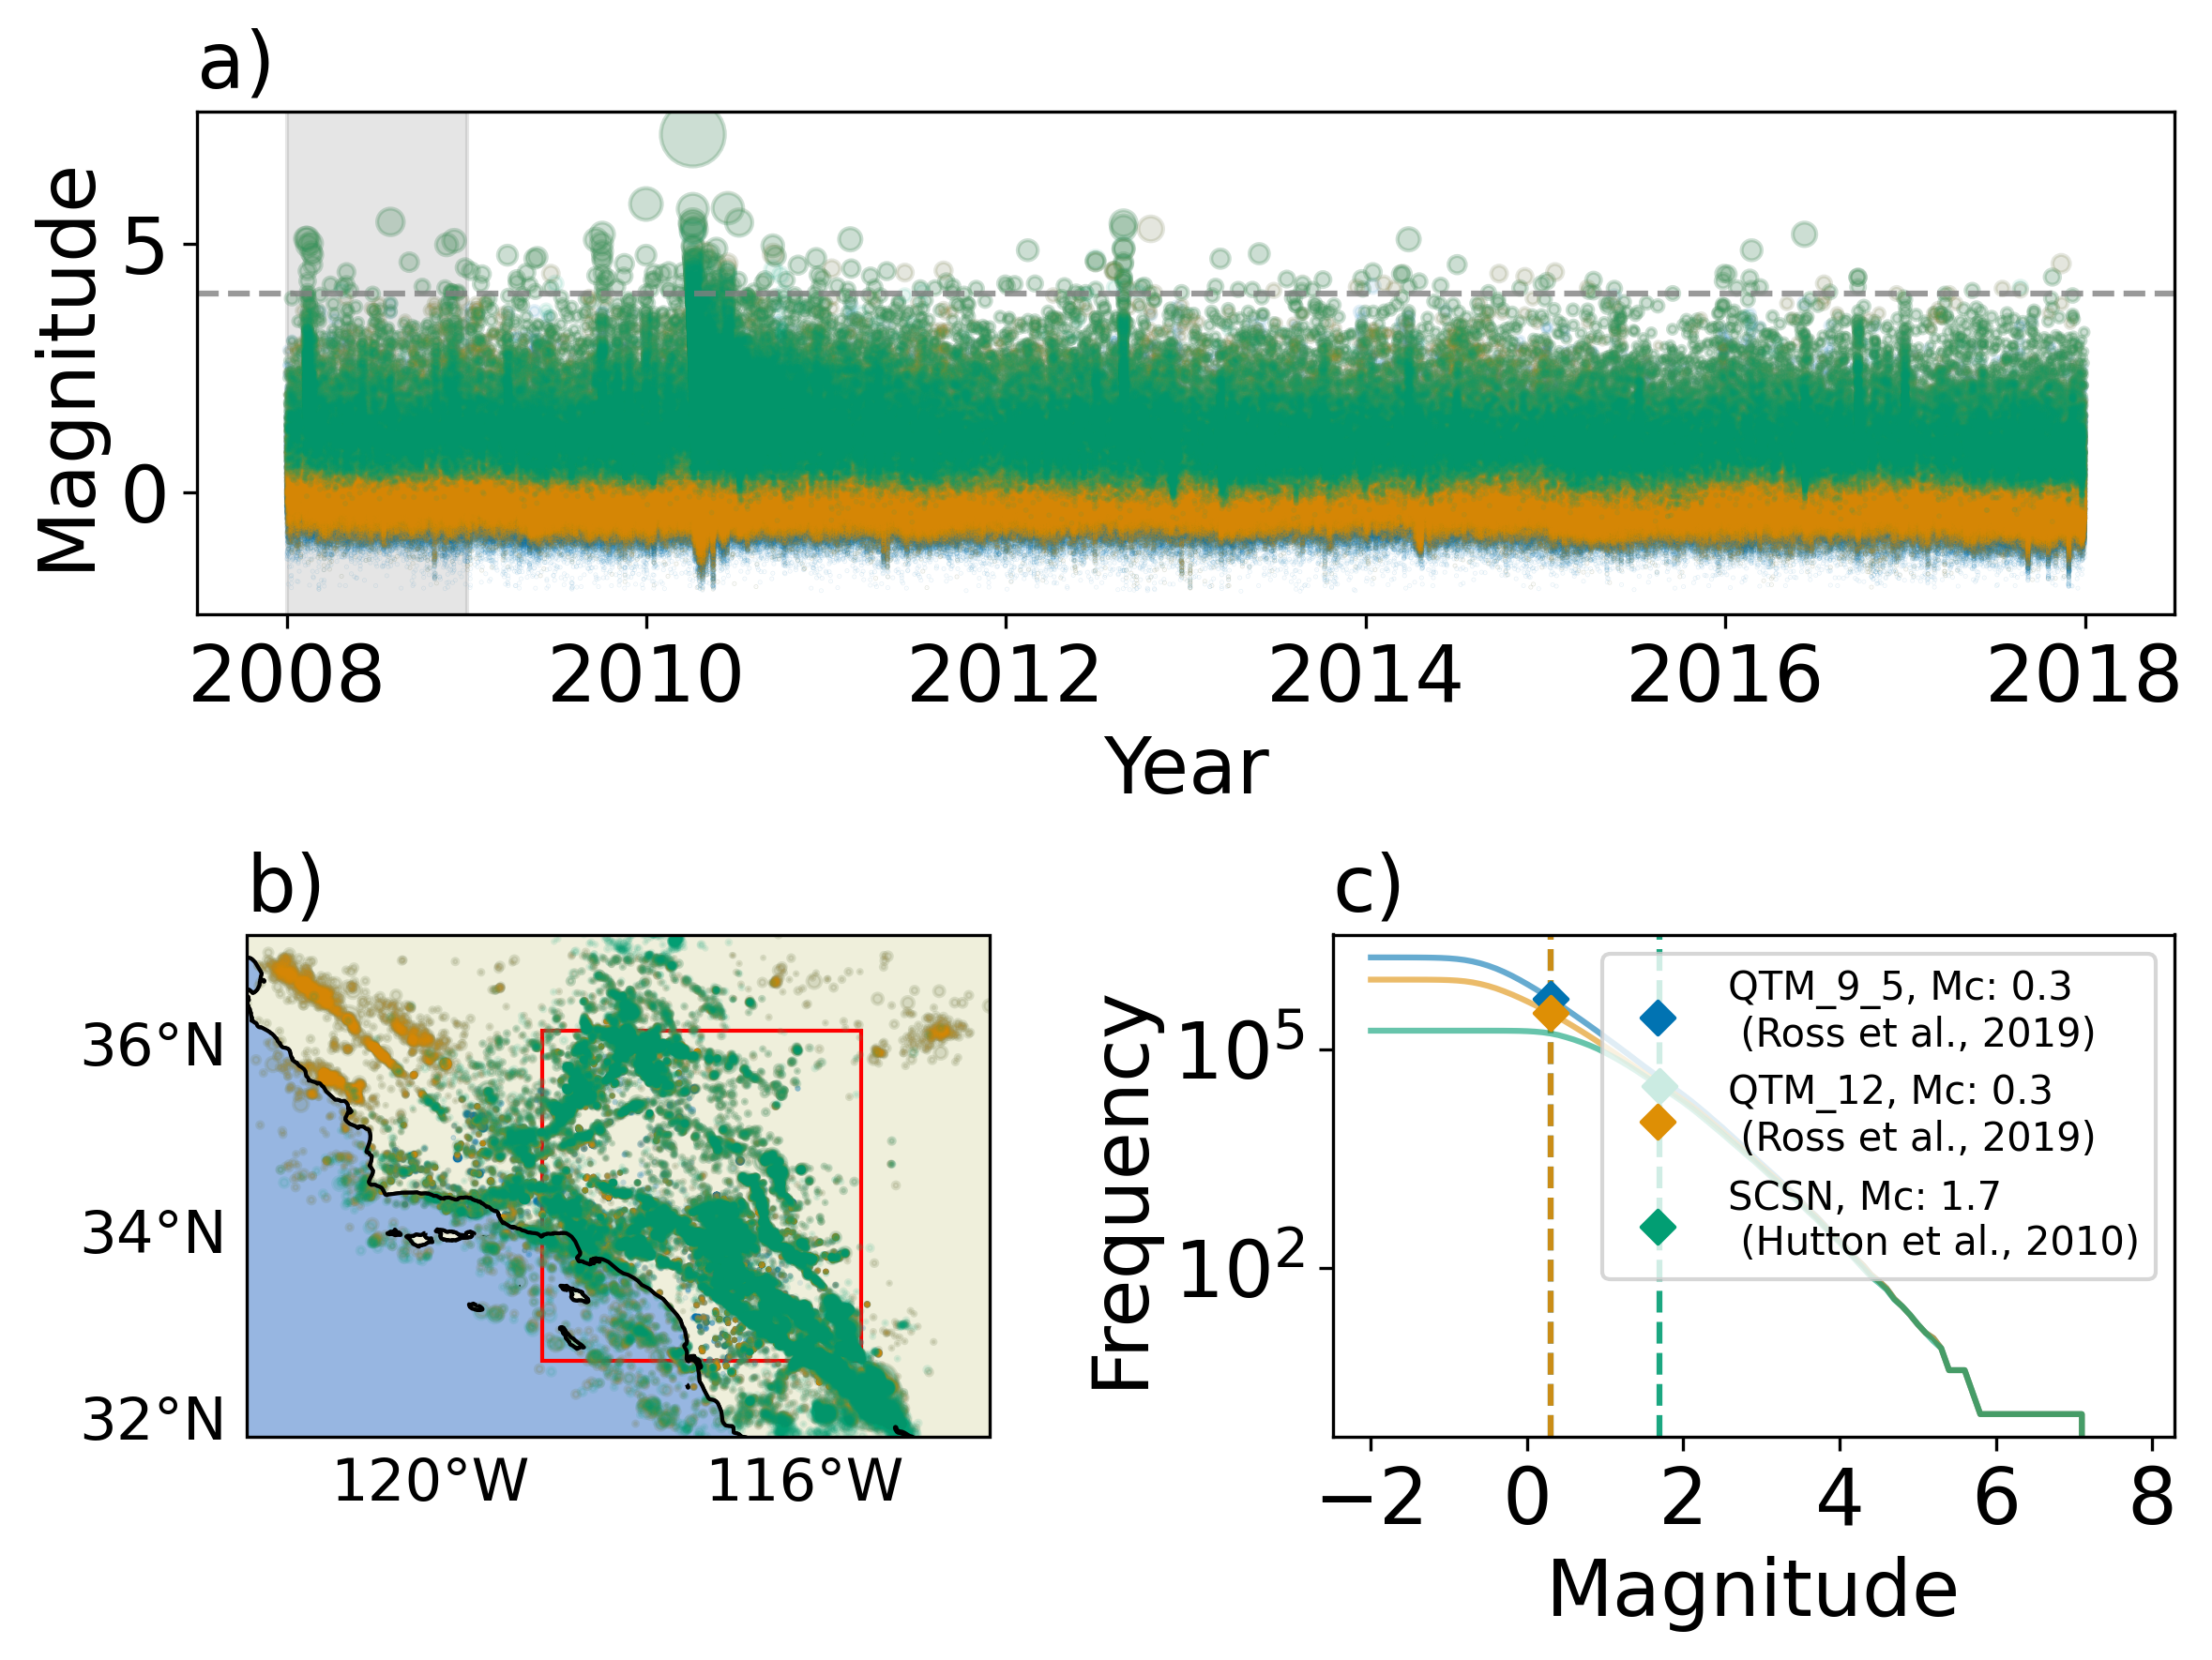

In [11]:
catalogue_dict = {key: catalogue_dict[key] for key in catalogue_names}

size = 1
scale=4
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_subplot(211)
ax1.set_title(f"a)", loc='left', fontsize=20)

ax1.set_xlabel(f"Year")
ax1.set_ylabel(f"Magnitude")

ax2 = fig.add_subplot(223, projection=ccrs.PlateCarree())
ax2.set_title(f"b)", loc='left', fontsize=20)

ax2.set_extent([-121.953, -114.026, 31.86317, 37.22333], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.LAND, edgecolor='black')
ax2.add_feature(cfeature.OCEAN, edgecolor='none')
gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=0)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
gl.xlines = False
gl.ylines = False
gl.ylocator = mticker.FixedLocator(range(32,38,2))
gl.xlocator = mticker.FixedLocator(np.arange(-120,-114,4))

rectangle_coords = [-118.8, -115.4, 32.68, 36.2]
rectangle = Rectangle(
    (rectangle_coords[0], rectangle_coords[2]),
    rectangle_coords[1] - rectangle_coords[0],
    rectangle_coords[3] - rectangle_coords[2],
    linewidth=1, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree()
)
ax2.add_patch(rectangle)

ax3 = fig.add_subplot(224)
ax3.set_title(f"c)", loc='left', fontsize=20)
ax3.set_xlabel('Magnitude')
ax3.set_ylabel('Frequency')

i = 0
Mc_list = [0.3, 0.3, 1.7]
ref_list = ['Ross et al., 2019', 'Ross et al., 2019', 'Hutton et al., 2010']
for name, catalogue in catalogue_dict.items():
    z = np.exp(catalogue['MAGNITUDE'])/5
    ax1.scatter(catalogue['DATETIME'], catalogue['MAGNITUDE'], alpha=0.1, color=colours[i], s=z)
    ax2.scatter(catalogue['LON'], catalogue['LAT'], alpha=0.1, transform=ccrs.PlateCarree(), s=z,  color=colours[i])

    a = np.log10(len(catalogue))
    bins = np.array(range(math.floor(catalogue['MAGNITUDE'].min())*10, math.ceil(catalogue['MAGNITUDE'].max())*10,1))/10
    values, base = np.histogram(catalogue['MAGNITUDE'], bins=bins)
    cumulative = np.cumsum(values)
    mark = utils.find_nearest(base, Mc_list[i])
    mark_index = np.where(base == mark)

    ax3.axvline(Mc_list[i], 
                color=colours[i], 
                alpha=0.9, linestyle='--',zorder=0)
    
    ax3.plot(base[:-1], len(catalogue)-cumulative,
             color=colours[i], 
             alpha=0.6
             )

    ax3.set_yscale("log")
    ax3.scatter(Mc_list[i], len(catalogue)-cumulative[mark_index], 
                color=colours[i],
                marker="D", zorder=5, 
             label=f"{name}, Mc: {Mc_list[i]} \n ({ref_list[i]})")
    i+=1

ax3.legend(loc='upper right', fontsize=10)
ax3.set_xticks(np.arange(-2,9,2))

ax1.axhline(4, color='grey', linestyle='--', alpha=0.8)
rectangle_coords = [dt.datetime(2008,1,1), dt.datetime(2009,1,1), -3, 8]
rectangle = Rectangle(
    (rectangle_coords[0], rectangle_coords[2]),
    rectangle_coords[1] - rectangle_coords[0],
    rectangle_coords[3] - rectangle_coords[2],
    linewidth=1, ec='grey', fc='grey', alpha=0.2, zorder=0
    )
ax1.add_patch(rectangle)

# plt.savefig('../outputs/figures/catalogues_multiplot.png')
plt.show()

## Catalog level Mc estimation comparison - Maxc, MBS, Lilliefors

QTM_9_5 3.3 -0.2
QTM_12 3.3 -0.2
SCSN 3.3 1.0


Text(0, 0.5, 'N')

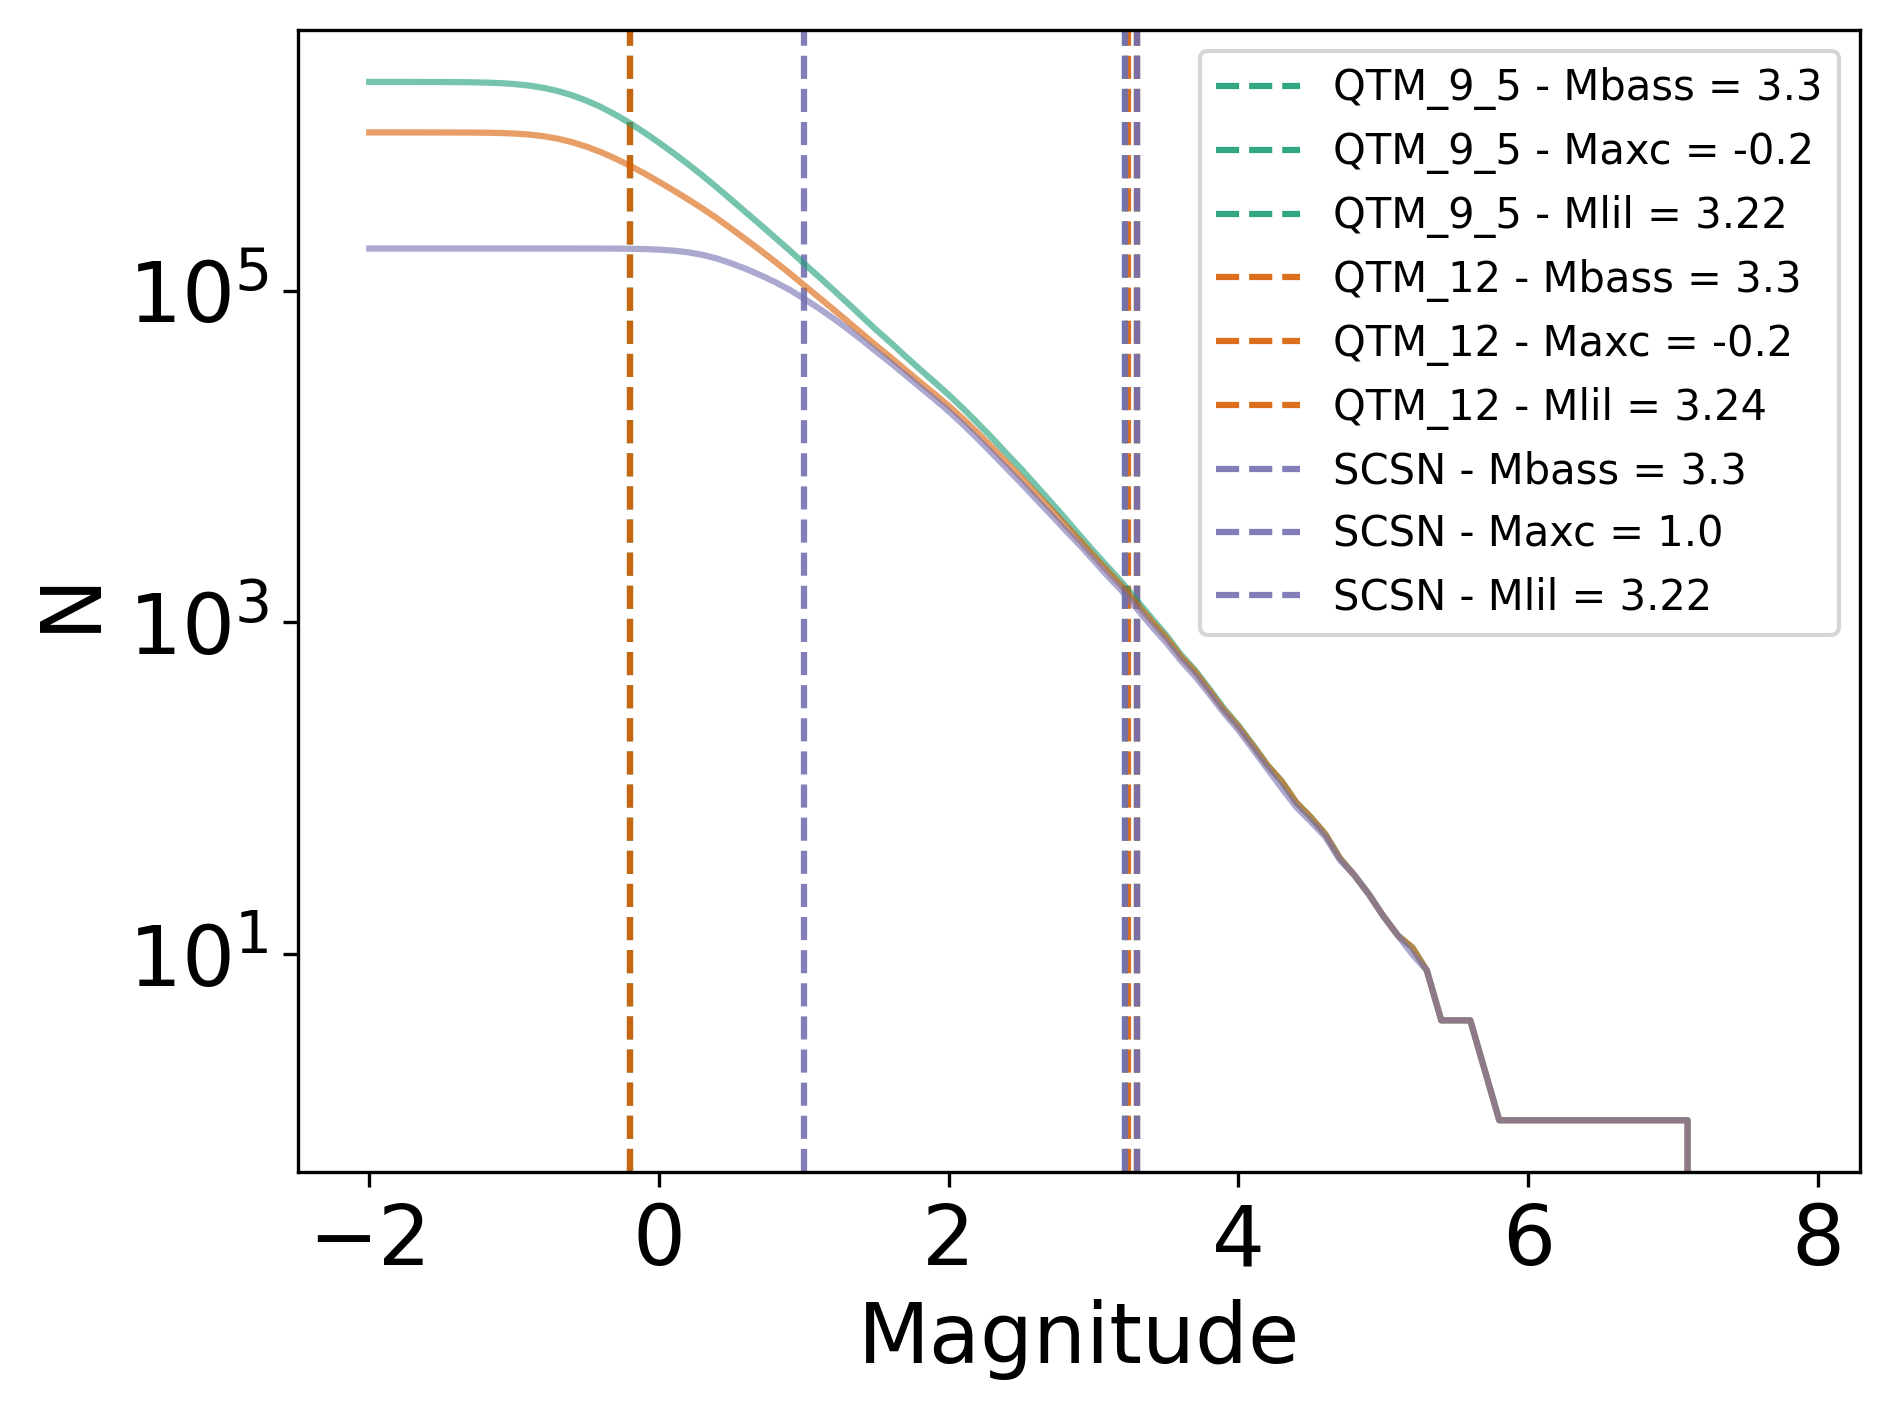

In [13]:
catalog_Mlils = [3.22, 3.24, 3.22]
fig = plt.figure()
ax3 = fig.add_subplot(111)
i=0
for key, catalogue in catalogue_dict.items():
    Mbass = mc.get_mbs(catalogue['MAGNITUDE'], mbin=0.1)[0]
    Maxc =  mc.get_maxc(catalogue['MAGNITUDE'], mbin=0.1)
    Mlil = catalog_Mlils[i]
    # MLil = lill.estimate_Mc_expon_test()

    Mc_dict = {'Mbass':Mbass, 
               'Maxc': Maxc,
               'Mlil':Mlil
               }
    print(key, Mbass, Maxc)

    a = np.log10(len(catalogue))
    bins = np.array(range(math.floor(catalogue['MAGNITUDE'].min())*10, math.ceil(catalogue['MAGNITUDE'].max())*10,1))/10
    values, base = np.histogram(catalogue['MAGNITUDE'], bins=bins)
    cumulative = np.cumsum(values)
    # mark = utils.find_nearest(base, Mbass['Mc'])
    # mark_index = np.where(base == mark)

    ax3.plot(base[:-1], len(catalogue)-cumulative, color=plot_colors[i], linewidth=1.5, alpha=0.6)

    for method, Mc in Mc_dict.items():
        ax3.axvline(Mc, linewidth=1.5, color=plot_colors[i], alpha=0.9, linestyle='--',zorder=0, label=f'{key} - {method} = {Mc}')

        # ax3.scatter(Mbass, len(catalogue)-cumulative[mark_index], color=plot_colors[i], label=fr"Mbass: {Mbass}",
        #             marker="D", zorder=5, s=size_dict['legend_markersize']*scale*scale)
    i+=1
ax3.set_yscale("log")
ax3.legend()
ax3.set_xlabel('Magnitude')
ax3.set_ylabel('N')

# plt.savefig('../outputs/rough/catalog_Mc_comp.png')

# 2. Select and analyse mainshocks

## Select mainshocks and create table

In [15]:
catalogue_dict = {key: catalogue_dict[key] for key in catalogue_names}

mainshock_table = []
mainshock_dict = {}
for name, data in catalogue_dict.items():
    mainshock_file = statseis.select_mainshocks(data, station_file=station_no_dup)
    mainshock_file = mainshock_file.loc[mainshock_file['DATETIME']>=dt.datetime(2009,1,1)].copy()
    mc.get_Mcs_400(mainshock_file, earthquake_catalogue=data, catalogue_name=name, min_n=275, max_r=50)
    Path(f'../data/{name}/').mkdir(parents=True, exist_ok=True)
    # mainshock_file.to_csv(f'../data/{name}/mainshocks.csv', index=False)
    both_selected = len(mainshock_file.loc[mainshock_file['Selection']=='Both'])
    MDET_selected = len(mainshock_file.loc[mainshock_file['Selection']=='MDET']) + both_selected
    FET_selected = len(mainshock_file.loc[mainshock_file['Selection']=='FET']) + both_selected

    N_Mw_4 =  len(mainshock_file)
    median_Mc = np.median(mainshock_file['Mc'])
    mean_Mc = np.mean(mainshock_file['Mc'])
    mainshock_table.append({'Catalogue':name,
                            'N_Mw_4_plus':N_Mw_4,
                            'MDET_selected':MDET_selected,
                            'FET_selected':FET_selected,
                            'Both_selected':both_selected,
                            'MDET_perc':round(100*MDET_selected/N_Mw_4),
                            'FET_perc':round(100*FET_selected/N_Mw_4),
                            'Both_perc':round(100*both_selected/N_Mw_4),
                            'median_Mc':median_Mc,
                            'mean_Mc':mean_Mc
                            })
    mainshock_dict[name] = mainshock_file

SCSN_mainshocks = mainshock_dict['SCSN']
QTM_12_mainshocks = mainshock_dict['QTM_12']
QTM_9_5_mainshocks = mainshock_dict['QTM_9_5']

mainshock_dict['Combined'] = pd.merge(pd.merge(SCSN_mainshocks, QTM_12_mainshocks, on='ID', how='inner', suffixes=('', '_QTM_12')), QTM_9_5_mainshocks, how='inner', on='ID', suffixes=('_SCSN', '_QTM_9_5'))
Combined_mainshocks = mainshock_dict['Combined'].copy()

mainshock_table = pd.DataFrame.from_dict(mainshock_table)
# mainshock_table.to_csv('../outputs/tables/mainshock_table.csv', index=False)
mainshock_table

100%|██████████| 257/257 [00:05<00:00, 43.46it/s]


,Catalogue,N_Mw_4_plus,MDET_selected,FET_selected,Both_selected,MDET_perc,FET_perc,Both_perc,median_Mc,mean_Mc
0,QTM_9_5,276,126,125,108,46,45,39,1.9,1.739855
1,QTM_12,270,124,124,107,46,46,40,1.9,1.740741
2,SCSN,257,106,108,88,41,42,34,1.9,1.836965


## Table: Combined catalog selections

In [16]:
combined_cat = pd.merge(pd.merge(SCSN, QTM_12, how='inner', on='ID', suffixes=('', '_QTM_12')), QTM_9_5, how='inner', on='ID', suffixes=('', '_QTM_9_5'))
combined_cat_restricted = utils.restrict_catalogue_geographically(combined_cat, region=region)
# catalogue_dict.update({'Combined':combined_cat})
# catalogue_dict.update({'Combined_restricted':combined_cat_restricted})

combined_mainshock_dict = {}
combined_mainshock_table = []
for cat in catalogue_dict.keys():
    mfile = mainshock_dict[cat].copy()
    mainshock_file =  mfile.loc[mfile['ID'].isin(combined_cat['ID'])].copy()
    both_selected = len(mainshock_file.loc[mainshock_file[f'Selection']=='Both'])
    MDET_selected = len(mainshock_file.loc[mainshock_file[f'Selection']=='MDET']) + both_selected
    FET_selected = len(mainshock_file.loc[mainshock_file[f'Selection']=='FET']) + both_selected
    N_Mw_4 =  len(mainshock_file)
    median_Mc = np.median(mainshock_file[f'Mc'])
    mean_Mc = np.mean(mainshock_file[f'Mc'])
    combined_mainshock_table.append({'Catalogue':f'{cat}_combined',
                            'N_Mw_4_plus':N_Mw_4,
                            'MDET_selected':MDET_selected,
                            'FET_selected':FET_selected,
                            'Both_selected':both_selected,
                            'MDET_perc':round(100*MDET_selected/N_Mw_4),
                            'FET_perc':round(100*FET_selected/N_Mw_4),
                            'Both_perc':round(100*both_selected/N_Mw_4),
                            'median_Mc':median_Mc,
                            'mean_Mc':mean_Mc
                            })
    combined_mainshock_dict[cat] = mainshock_file
combined_mainshock_table = pd.DataFrame.from_dict(combined_mainshock_table)
combined_mainshock_table

,Catalogue,N_Mw_4_plus,MDET_selected,FET_selected,Both_selected,MDET_perc,FET_perc,Both_perc,median_Mc,mean_Mc
0,QTM_9_5_combined,249,103,103,86,41,41,35,1.9,1.691566
1,QTM_12_combined,249,103,103,86,41,41,35,1.9,1.688353
2,SCSN_combined,248,102,103,85,41,42,34,1.9,1.816532


### Analysis of selections

In [ ]:
mshocks_merged_on_ID_and_state = pd.merge(combined_mainshock_dict['SCSN'], combined_mainshock_dict['QTM_12'], how='inner', on=['ID', 'Selection'], suffixes=('', '_QTM_12'))
QTM_12_merged_mshocks = QTM_12_mainshocks.loc[QTM_12_mainshocks['ID'].isin(mshocks_merged_on_ID_and_state['ID'])]
SCSN_merged_mshocks = SCSN_mainshocks.loc[SCSN_mainshocks['ID'].isin(mshocks_merged_on_ID_and_state['ID'])]
SCSN_merged_mshocks_restrict = utils.restrict_catalogue_geographically(SCSN_merged_mshocks, region=region)
QTM_12_merged_mshocks_restrict = utils.restrict_catalogue_geographically(QTM_12_merged_mshocks, region=region)
print(len(SCSN_merged_mshocks_restrict), len(QTM_12_merged_mshocks_restrict))
QTM_12_merged_mshocks_restrict.loc[~QTM_12_merged_mshocks_restrict['ID'].isin(SCSN_merged_mshocks_restrict['ID'])]

In [ ]:
SCSN_merged_mshocks_restrict.loc[~SCSN_merged_mshocks_restrict['ID'].isin(QTM_12_merged_mshocks_restrict['ID'])]

In [ ]:
statseis.mainshock_selections_counts(mshocks_merged_on_ID_and_state)

In [ ]:
statseis.mainshock_selections_counts(QTM_12_merged_mshocks_restrict)

In [ ]:
statseis.mainshock_selections_counts(SCSN_merged_mshocks_restrict)

In [ ]:
x = combined_mainshock_dict['SCSN'].copy()
y = combined_mainshock_dict['QTM_12'].copy()

x2 = x.loc[~x['ID'].isin(mshocks_merged_on_ID_and_state['ID'])].copy()
y2 = y.loc[~y['ID'].isin(mshocks_merged_on_ID_and_state['ID'])].copy()

differing_selections = pd.merge(x2, y2, on='ID', how='inner', suffixes=('_SCSN', '_QTM_12'))
len(differing_selections)
differing_selections[['Selection_SCSN', 'Selection_QTM_12']]

In [ ]:
region = [-118.80, -115.40, 32.68, 36.20]
for key, item in mainshock_dict.items():
    if key!='Combined':
        print(key)
        r = utils.restrict_catalogue_geographically(item, region=region)
        print(len(r))
        for selection in ['Both', 'FET', 'MDET']:
            s = r.loc[r['Selection']==selection].copy()
            print(selection, len(s))

## Analysing Mc and b-values around mainshocks

We estimate $M_{c}$ using the maximum curvature method (MAXC), the b-value stability method (MBS).  
We choose a 10 km radius around mainshock epicenters, and set a threshold of 275 events.  
We expand the radius by 5 km, up to 50 km, until the threshold is reached.

We choose 275 events as our threshold as this is around the value where the b-values using our $M_{c}$ estimates drop off.  
We believe this to be a reasonable threshold based on the performance of the $M_{c}$ by b-value stability method (MBS):  
(http://www.corssa.org/export/sites/corssa/.galleries/articles-pdf/Mignan-Woessner-2012-CORSSA-Magnitude-of-completeness.pdf).  

Some mainshocks occur in regions with too few events to make a robust estimate of $M_{c}$.  
  
Some mainshocks have <10 events within 10 km in the past year. We look at these mainshocks too.

### Comparing Mc in SCSN to QTM
Mc by b-value stability (MBS) method.  
Do the catalogs have the same Mc around mainshocks, or is there a significant difference?

In [ ]:
mainshock_file = good_mainshocks.copy() #DDET_mainshocks

fig = plt.figure(figsize=(8,6))
i,j = 2,2

ax = fig.add_subplot(i,j,1)
ax.hist(mainshock_file['Mc'], alpha=0.5, label='SCSN', bins=np.arange(-0.2, 2.5, 0.2))
ax.hist(mainshock_file['Mc_QTM_12'], alpha=0.5,  label='QTM 12', bins=np.arange(-0.2, 2.5, 0.2))
ax.set_xlabel(f'$M_c$')
ax.set_ylabel(f'N')
ax.legend()

ax = fig.add_subplot(i,j,2)
ax.scatter(mainshock_file['Mc'], mainshock_file['Mc_QTM_12'], ec='white', linewidth=0.5)
ax.set_xlabel(f'SCSN $M_c$')
ax.set_ylabel(f'QTM 12 $M_c$')
ax.plot(range(0,3), range(0,3), label='1:1')
ax.legend()

ax = fig.add_subplot(i,j,3)
ax.hist(mainshock_file['n_local_cat_1yr'], alpha=0.5, label='SCSN', bins=np.arange(0, 3500, 100))
ax.hist(mainshock_file['n_local_cat_1yr_QTM_12'], alpha=0.5,  label='QTM 12', bins=np.arange(0, 3500, 100))
ax.set_xlabel('local catalog n')
ax.set_ylabel(f'N')
ax.legend()
ax.set_xlim(0,2500)

ax = fig.add_subplot(i,j,4)
ax.scatter(mainshock_file['n_local_cat_1yr'], mainshock_file['n_local_cat_1yr_QTM_12'], ec='white', linewidth=0.5)
ax.set_xlabel(f'SCSN N')
ax.set_ylabel(f'QTM 12 N')
ax.plot(range(0,1000), range(0,1000), label='1:1')
ax.legend()
ax.set_ylim(0,2500)

# plt.savefig('../outputs/rough/Mc_catalog_comp.png')

### Mc in SCSN vs QTM, and MBS vs MaxC

In [ ]:
ID = 37301704#37265488
name = 'SCSN'
catalog = catalogue_dict[name].copy()
mainshock = statseis.iterable_mainshock(ID, SCSN_mainshocks)
local_cat_SCSN = statseis.create_local_catalogue(mainshock=mainshock, earthquake_catalogue=catalog, catalogue_name=name, radius_km=50)

name = 'QTM_12'
catalog = catalogue_dict[name].copy()
mainshock = statseis.iterable_mainshock(ID, QTM_12_mainshocks)
local_cat_QTM_12 = statseis.create_local_catalogue(mainshock=mainshock, earthquake_catalogue=catalog, catalogue_name=name, radius_km=50)

len(local_cat_SCSN), len(local_cat_QTM_12)

fig = plt.figure()
ax = fig.add_subplot(111)
for cat in [local_cat_SCSN, local_cat_QTM_12]:
    magnitudes = cat['MAGNITUDE']
    magnitudes = np.array(magnitudes)
    bins = np.arange(math.floor(magnitudes.min()), math.ceil(magnitudes.max()), 0.1)
    values, base = np.histogram(magnitudes, bins=bins)
    cumulative = np.cumsum(values)
    ax.step(base[:-1], len(magnitudes)-cumulative, color='black')
    Mc, this_fmd, b, b_avg, shibolt_unc = mc.get_mbs(mag=magnitudes, mbin=0.1)
    a, b_value, _a, _b = statseis.b_est(mag=np.array(cat['MAGNITUDE']), mbin=0.1, mc=Mc)
    ax.axvline(x=Mc, linestyle='--', label=r'$M_{c}$: ' + str(round(Mc,1)), color=plot_colors[0])

    N = [10**(a-b_value*M) for M in this_fmd]
    ax.plot(this_fmd, N, label=f'b: {round(b_value,2)}',  color=plot_colors[1])

    n_above_Mc = len(magnitudes[magnitudes>Mc])
    ratio_above_Mc = round(100*n_above_Mc/len(magnitudes))
    ax.plot([], [], label=f'{len(magnitudes)} events', marker=None, linestyle='')
    ax.plot([], [], label=f'{n_above_Mc} above $M_c$ ({ratio_above_Mc}%)', marker=None, linestyle='')

ax.set_xlabel('Magnitude')
ax.set_ylabel('N')
# axs[Mc_plot].legend()
ax.set_yscale('log')
ax.legend()

In [ ]:
plt.hist(DDET_mainshocks['Mc'] - DDET_mainshocks['Mc_QTM_12'])

In [ ]:
fig = plt.figure(figsize=(10,8))

b = DDET_mainshocks['Mc'] - DDET_mainshocks['Mc_QTM_12']
sorted_data = np.sort(b)
# pdf = b/sum(b)
# cdf = np.cumsum(pdf)
cdf = np.arange(1, len(sorted_data) + 1)/len(b)

ax=fig.add_subplot(111)
ax.step(sorted_data, cdf)
percentiles = np.percentile(sorted_data, [25, 50, 75])
cdf_percentiles = np.array([0.25, 0.5, 0.75])
# for percentile, cdf_percentile in zip(percentiles, cdf_percentiles):

#     plt.vlines(percentile, ymin=0, ymax=cdf_percentile, color='red', linestyle='--', alpha=0.5)
    
#     # Annotate the percentiles
#     plt.text(percentile, cdf_percentile, f'{percentile:.2f}', ha='center', va='top', color='black', fontsize=20)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(f'$\delta$ $M_c$ (SCSN $M_c$ - QTM 12 $M_c$)')
plt.ylabel('CDF')
plt.grid(True)

plt.show()

In [ ]:
mainshock_dict = {}
for name, data in catalogue_dict.items():
    mainshock_file = statseis.select_mainshocks(data)
    mainshock_file = mainshock_file.loc[mainshock_file['DATETIME']>=dt.datetime(2009,1,1)].copy()
    mc.get_Mcs_400(mainshock_file, earthquake_catalogue=data, catalogue_name=name, min_n=275, max_r=50)
    both_selected = len(mainshock_file.loc[mainshock_file['Selection']=='Both'])
    MDET_selected = len(mainshock_file.loc[mainshock_file['Selection']=='MDET']) + both_selected
    FET_selected = len(mainshock_file.loc[mainshock_file['Selection']=='FET']) + both_selected
    
    mainshock_dict[name] = mainshock_file

SCSN_mainshocks = mainshock_dict['SCSN']
QTM_12_mainshocks = mainshock_dict['QTM_12']
QTM_9_5_mainshocks = mainshock_dict['QTM_9_5']

mainshock_dict['Combined'] = pd.merge(pd.merge(SCSN_mainshocks, QTM_12_mainshocks, on='ID', how='inner', suffixes=('', '_QTM_12')), QTM_9_5_mainshocks, how='inner', on='ID', suffixes=('', '_QTM_9_5'))
Combined_mainshocks = mainshock_dict['Combined'].copy()

In [ ]:
Combined_DDET_mainshocks = Combined_mainshocks.loc[Combined_mainshocks['ID'].isin(good_mainshocks['ID'])].copy()
Combined_DDET_mainshocks.reset_index(inplace=True, drop=True)
Combined_DDET_mainshocks

In [ ]:
Combined_DDET_mainshocks.loc[Combined_DDET_mainshocks['Mc']<Combined_DDET_mainshocks['Mc_QTM_12']][['Mc', 'Mc_QTM_12', 'Mc_QTM_9_5']]

In [ ]:
Combined_DDET_mainshocks.loc[Combined_DDET_mainshocks['Mc']<Combined_DDET_mainshocks['Mc_QTM_9_5']][['Mc', 'Mc_QTM_12', 'Mc_QTM_9_5']]

In [ ]:
Combined_DDET_mainshocks.loc[Combined_DDET_mainshocks['Maxc_50']<Combined_DDET_mainshocks['Maxc_50_QTM_12']][['ID', 'Maxc_50', 'Maxc_50_QTM_12', 'Maxc_50_QTM_9_5']]

In [ ]:
Combined_DDET_mainshocks.loc[Combined_DDET_mainshocks['Maxc_50']<Combined_DDET_mainshocks['Maxc_50_QTM_9_5']][['ID', 'Maxc_50', 'Maxc_50_QTM_12', 'Maxc_50_QTM_9_5']]

In [ ]:
fig = plt.figure(figsize=(10,8))

b = Combined_DDET_mainshocks['Mc'] - Combined_DDET_mainshocks['Mc_QTM_12']
sorted_data = np.sort(b)
# pdf = b/sum(b)
# cdf = np.cumsum(pdf)
cdf = np.arange(1, len(sorted_data) + 1)/len(b)

ax=fig.add_subplot(111)
ax.step(sorted_data, cdf)
percentiles = np.percentile(sorted_data, [25, 50, 75])
cdf_percentiles = np.array([0.25, 0.5, 0.75])
# for percentile, cdf_percentile in zip(percentiles, cdf_percentiles):

#     plt.vlines(percentile, ymin=0, ymax=cdf_percentile, color='red', linestyle='--', alpha=0.5)
    
#     # Annotate the percentiles
#     plt.text(percentile, cdf_percentile, f'{percentile:.2f}', ha='center', va='top', color='black', fontsize=20)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(f'$\delta$ $M_c$ (SCSN $M_c$ - QTM 12 $M_c$)')
plt.ylabel('CDF')
plt.grid(True)

plt.show()

In [ ]:
fig = plt.figure(figsize=(6,8))
i, j = 6,1
ax = fig.add_subplot(i,j,1)
nearest=0.1
x = DDET_mainshocks['Maxc']
ax.hist(x, bins=utils.get_bins(x, nearest=nearest), alpha=0.5, label='Maxc_10')
x = DDET_mainshocks['Mbass']
ax.hist(x, bins=utils.get_bins(x, nearest=nearest), alpha=0.5, label='Mbass_10')
ax.legend()
ax.set_xlim(0,4.2)

ax = fig.add_subplot(i,j,2)
x = DDET_mainshocks['Maxc_50']
ax.hist(x, bins=utils.get_bins(x, nearest=nearest), alpha=0.5, label='Maxc_50')
x = DDET_mainshocks['Mbass_50']
ax.hist(x, bins=utils.get_bins(x, nearest=nearest), alpha=0.5, label='Mbass_50')
ax.legend()
ax.set_xlim(0,4.2)

ax = fig.add_subplot(i,j,3)
x = DDET_mainshocks['Maxc_50'] - DDET_mainshocks['Maxc']
ax.hist(x, bins=utils.get_bins(x, nearest=0.05), alpha=0.5, label='Maxc_50 - Maxc')
x = DDET_mainshocks['Mbass_50'] - DDET_mainshocks['Mbass']
ax.hist(x, bins=utils.get_bins(x, nearest=0.05), alpha=0.5, label='Mbass_50 - Mbass')
ax.legend()

ax = fig.add_subplot(i,j,4)
x = DDET_mainshocks['Maxc_50'] - DDET_mainshocks['Mbass_50']
ax.hist(x, bins=utils.get_bins(x, nearest=0.05), alpha=0.5, label='Maxc_50 - Mbass_50')
x = DDET_mainshocks['Maxc'] - DDET_mainshocks['Mbass']
ax.hist(x, bins=utils.get_bins(x, nearest=0.05), alpha=0.5, label='Maxc - Mbass')
ax.legend()

ax = fig.add_subplot(i,j,5)
x = DDET_mainshocks['b_Mbass']
ax.hist(x, bins=utils.get_bins(x, nearest=nearest), alpha=0.5, label='b_Mbass')
x = DDET_mainshocks['b_maxc']
ax.hist(x, bins=utils.get_bins(x, nearest=nearest), alpha=0.5, label='b_maxc')
ax.legend()
ax.set_xlim(0,4.2)

ax = fig.add_subplot(i,j,6)
x = DDET_mainshocks['b_Mbass_50']
ax.hist(x, bins=utils.get_bins(x, nearest=nearest), alpha=0.5, label='b_Mbass_50')
x = DDET_mainshocks['b_Maxc_50']
ax.hist(x, bins=utils.get_bins(x, nearest=nearest), alpha=0.5, label='b_Maxc_50')
ax.legend()
ax.set_xlim(0,4.2)

In [ ]:
b_value_dict = {'b_Mbass':{}, 'b_maxc':{}, 'b_Mbass_50':{}, 'b_Maxc_50':{}}
for key, item in b_value_dict.items():
    b = DDET_mainshocks[key]
    item.update({'mean':np.mean(b),
                'median':np.nanmedian(b),
                'std':np.std(b),
                'var':np.var(b),
                'se':np.std(b)/np.sqrt(len(b)),
                '5_per':np.percentile(b, 5),
                '95_per':np.percentile(b, 95)
                })

b_df = pd.DataFrame.from_dict(b_value_dict)
b_df

In [ ]:
for col in b_df:
    print(col, len(DDET_mainshocks.loc[(DDET_mainshocks[col]<=b_value_dict[col]['mean']-b_value_dict[col]['std']) |\
                    (DDET_mainshocks[col]>=b_value_dict[col]['mean']+b_value_dict[col]['std'])]))

In [ ]:
c,r = 2,2
fig = plt.figure(figsize=(8,6), dpi=300)
ax = fig.add_subplot(c,r,1)
sns.histplot(DDET_mainshocks['radii_50'], ax=ax)

ax = fig.add_subplot(c,r,2)
ax.scatter(DDET_mainshocks['radii_50'], DDET_mainshocks['n_for_Mc_50'])
ax.axhline(275, color='grey', linestyle='--')
ax.set_yscale('log')
ax.set_ylabel('n_for_Mc')
ax.set_xlabel('radius')

ax = fig.add_subplot(c,r,3)
sns.histplot(DDET_mainshocks['Mbass'])

ax = fig.add_subplot(c,r,4)
sns.histplot(DDET_mainshocks['n_for_Mc_50'])

### Plotting FMDs for one mainshock and all mainshocks

In [ ]:
mainshock = statseis.iterable_mainshock(ID=14477000, mainshock_file=DDET_mainshocks)
catalog = catalogue_dict['QTM_12'].copy()
local_cat = statseis.create_local_catalogue(mainshock, earthquake_catalogue=catalog, catalogue_name=name, radius_km=100)
statseis.plot_local_cat(mainshock=mainshock, local_cat=local_cat, catalogue_name=name, Mc_cut=False, stations=station_df, earthquake_catalogue=catalog,
                min_days=math.ceil(local_cat['DAYS_TO_MAINSHOCK'].max()), max_days=0,
                radius_km=mainshock.radii_50, box_halfwidth_km=100, aftershock_days=math.floor(local_cat['DAYS_TO_MAINSHOCK'].min()))
print(mainshock.n_for_Mc_50)
statseis.plot_fmd(local_cat, save_path=f'../outputs/rough/{mainshock.ID}.png', ID=mainshock.ID, radius=mainshock.radii_50)

In [ ]:
name = 'SCSN'
statseis.plot_FMD_mainshock_subset(mshock_file=DDET_mainshocks,  outfile_name='DDET_mainshocks', name=name, catalog=catalogue_dict[name])
for plot_type in ['data_plots', 'model_plots']:
    statseis.move_plots(mshock_file=DDET_mainshocks, out_folder_name='DDET_mainshocks', catalog=name, plot_type=plot_type)

### Mainshocks with <275 events within 50 km

In [ ]:
# DDET_mainshocks.loc[DDET_mainshocks.isnull().any(axis=1)]

bad_mainshocks = DDET_mainshocks.loc[(DDET_mainshocks['n_for_Mc_50']<275)].copy()
bad_mainshocks.to_csv('../outputs/bad_mainshocks.csv', index=False)
# bad_mainshocks.sort_values(by='ID')[['ID', 'MAGNITUDE', 'n_local_cat_1yr', 'n_local_cat', 'n_for_Mc_50', 'Mbass', 'Mbass_50', 'b_Mbass', 'b_Mbass_50', 'Maxc_50', 'b_Maxc_50', 'radii_50', 'km_to_STA', 'LAT',  'STA_4_km']]

good_mainshocks = DDET_mainshocks.loc[(DDET_mainshocks['n_for_Mc_50']>=275)].copy()
good_mainshocks.to_csv('../outputs/good_mainshocks.csv', index=False)
# good_mainshocks.sort_values(by='STA_4_km')[['ID', 'MAGNITUDE', 'n_local_cat_1yr', 'n_local_cat', 'n_for_Mc_50', 'Mbass', 'Mbass_50', 'b_Mbass', 'b_Mbass_50', 'Maxc_50', 'b_Maxc_50', 'radii_50', 'km_to_STA', 'STA_4_km']]

name='SCSN'
statseis.plot_FMD_mainshock_subset(mshock_file=bad_mainshocks, name = name, outfile_name = 'bad_mainshocks', catalog=catalogue_dict[name])
for plot_type in ['data_plots', 'model_plots']:
    statseis.move_plots(mshock_file=bad_mainshocks, catalog = 'SCSN', plot_type = plot_type, out_folder_name='bad_mainshocks')

fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
utils.basic_cartopy_map(ax)

ax.scatter(DDET_mainshocks['LON'], DDET_mainshocks['LAT'], label='All', fc=plot_color_dict['teal'], ec='white', linewidth=0.25, s=200, zorder=100)
ax.scatter(bad_mainshocks['LON'], bad_mainshocks['LAT'], label='<250 events', fc=plot_color_dict['orange'], ec='white', linewidth=0.25, s=200, zorder=101)
ax.scatter(station_no_dup['LON'], station_no_dup['LAT'],  marker='^', fc=plot_color_dict['pink'], linewidth=0.25, ec='white', #fc='None',
            label='STA', zorder=102)
extent = utils.get_catalogue_extent(DDET_mainshocks, buffer=0.5)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.legend()

# plt.savefig('../outputs/rough/bad_mainshocks_map.png')

### Mainshocks with less than 10 events 1 year prior

In [ ]:
l10_events = DDET_mainshocks.loc[(DDET_mainshocks['n_local_cat_1yr']<10) & ~(DDET_mainshocks['ID'].isin(bad_mainshocks['ID']))].copy()
# l10_events = DDET_mainshocks.loc[(DDET_mainshocks['n_local_cat_1yr']<10)].copy()
print(len(l10_events), len(DDET_mainshocks.loc[~DDET_mainshocks['ID'].isin(l10_events['ID']) & ~(DDET_mainshocks['ID'].isin(bad_mainshocks['ID']))]))
# l10_events.sort_values(by='n_local_cat_1yr')[['ID', 'n_local_cat_1yr', 'n_local_cat', 'n_for_Mc_50', 'Mbass', 'Mbass_50', 'b_Mbass', 'b_Mbass_50', 'Maxc_50', 'b_Maxc_50', 'radii_50', 'km_to_STA', 'LAT']]

name='SCSN'
statseis.plot_FMD_mainshock_subset(mshock_file=l10_events,  outfile_name='l10_events', name=name, catalog=catalogue_dict[name])
for plot_type in ['data_plots', 'model_plots']:
    statseis.move_plots(mshock_file=l10_events, catalog = 'SCSN', plot_type = plot_type, out_folder_name='l10_events')

fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

utils.basic_cartopy_map(ax)

ax.scatter(DDET_mainshocks['LON'], DDET_mainshocks['LAT'], label='All', fc=plot_color_dict['teal'], ec='white', linewidth=0.25, s=200, zorder=100)
ax.scatter(l10_events['LON'], l10_events['LAT'], label='<10 events 1yr prior', fc=plot_color_dict['orange'], ec='white', linewidth=0.25, s=200, zorder=101)
ax.scatter(bad_mainshocks['LON'], bad_mainshocks['LAT'], label='<250 events total', fc=plot_color_dict['purple'], ec='white', linewidth=0.25, s=200, zorder=101)
ax.scatter(station_no_dup['LON'], station_no_dup['LAT'],  marker='^', fc=plot_color_dict['pink'], linewidth=0.25, ec='white', #fc='None',
            label='STA', zorder=102)
extent = utils.get_catalogue_extent(DDET_mainshocks, buffer=0.5)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.legend()

# plt.savefig('../outputs/rough/l10_1yr_prior_map.png')

### 4th station effect

In [ ]:
DDET_mainshocks.loc[DDET_mainshocks['n_local_cat']<250].sort_values(by='n_local_cat')[['ID', 'n_local_cat', 'n_for_Mc_50', 'Mbass', 'Mbass_50', 'b_Mbass', 'b_Mbass_50', 'Maxc_50', 'b_Maxc_50', 'radii_50', 'km_to_STA']]

In [ ]:
fig = plt.figure(figsize=(6,8))
i, j = 2,2
ax = fig.add_subplot(i,j,1)
ax.scatter(DDET_mainshocks['STA_4_km'], DDET_mainshocks['Mbass_50'])

ax = fig.add_subplot(i,j,2)
ax.scatter(DDET_mainshocks['STA_4_km'], DDET_mainshocks['Maxc_50'])

ax = fig.add_subplot(i,j,3)
ax.scatter(DDET_mainshocks['STA_4_km'], DDET_mainshocks['Mbass'])

ax = fig.add_subplot(i,j,4)
ax.scatter(DDET_mainshocks['STA_4_km'], DDET_mainshocks['Maxc'])

### Calculating Mc for an expanding radius

In [ ]:
bad_mainshocks = pd.read_csv('../outputs/bad_mainshocks.csv')
utils.string_to_datetime_df(bad_mainshocks)
bad_mainshocks

In [ ]:
Mc_expanding_r = statseis.get_Mc_expanding_r(bad_mainshocks, SCSN, 'SCSN', max_r=100)
Mc_expanding_r

In [ ]:
fig = plt.figure(figsize=(10,8))
i, j = 3,2
ax = fig.add_subplot(i,j,1)
ax2 = fig.add_subplot(i,j,2)
ax3 = fig.add_subplot(i,j,3)
ax4 = fig.add_subplot(i,j,4)
ax5 = fig.add_subplot(i,j,5)
ax6 = fig.add_subplot(i,j,6)

for mainshock in Mc_expanding_r:
    df = mainshock['df'].copy()
    ax.plot(df['radii'], df['Mbass'])
    ax2.plot(df['radii'], df['Maxc'])
    ax3.plot(df['radii'], df['b_Mbass'])
    ax4.plot(df['radii'], df['n_local_cat'])
    ax5.plot(df['n_local_cat'], df['Mbass'])
    ax6.plot(df['n_local_cat'], df['Maxc'])


for axes in fig.get_axes():
    axes.set_xlabel('radius')

ax.set_ylabel(f'$M_c$ Mbass')
ax2.set_ylabel(f'Mc maxc')
ax3.set_ylabel(f'b-value')
ax4.set_ylabel(f'n')

ax5.set_ylabel(f'$M_c$ Mbass')
ax5.set_xlabel('n')
ax5.set_xscale('log')

ax6.set_ylabel(f'$M_c$ Maxc')
ax6.set_xlabel('n')
ax6.set_xscale('log')

# plt.savefig('../outputs/rough/Mc_by_radius.png')

## Figure: Differences between FET and MDET mainshocks

In [ ]:
alphabet = string.ascii_lowercase
rows, cols = 2, 2
n_plots = rows*cols
labels = [letter + ')' for letter in alphabet[:n_plots]]
QTM_12_mainshocks = mainshock_dict['QTM_12'].copy()
# QTM_12_mainshocks = mainshocks_in_all.copy()
El_Mayor = QTM_12_mainshocks.loc[QTM_12_mainshocks['MAGNITUDE']>7].iloc[0]

El_Mayor_data = QTM_12_mainshocks.loc[(QTM_12_mainshocks['DATETIME'] > pd.Timestamp(2010,1,1)) &\
                                      (QTM_12_mainshocks['DATETIME'] < pd.Timestamp(2011,4,4))].copy()
El_Mayor_data = utils.restrict_catalogue_geographically(El_Mayor_data, region=[-116,-115, 32, 33])

El_Mayor_data_dict = {'All':El_Mayor_data}
QTM_12_mainshock_dict = {'All':QTM_12_mainshocks}
options = ['Neither', 'Both', 'FET', 'MDET']
for option in options:
    EM_data = El_Mayor_data.loc[El_Mayor_data['Selection']==option].copy()
    QTM_12_data = QTM_12_mainshocks.loc[QTM_12_mainshocks['Selection']==option].copy()
    print(f"{option}: {len(QTM_12_data)}")
    El_Mayor_data_dict.update({option:EM_data})
    QTM_12_mainshock_dict.update({option:QTM_12_data})

box_alpha = 0.2
fig = plt.figure(figsize=(10,8))
gs = fig.add_gridspec(2,2)

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
# ax1.set_extent([-121.953, -114.026, 31.86317, 37.22333], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
# ax2.set_extent([-116,-115, 32, 33], crs=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

i = 0
QTM_legend_labels = []
EM_legend_labels = []
for option in options:
    EM_data = El_Mayor_data_dict[option]
    QTM_12_data = QTM_12_mainshock_dict[option]

    if option=='Neither':
        colour='grey'
        EM_size, QTM_size = [10]*2
        i-=1
    else:
        colour=colours[i]
        QTM_size = 2*QTM_12_data['MAGNITUDE']**2
        EM_size = 2*EM_data['MAGNITUDE']**2

    QTM_legend_labels.append(f"{option}: {len(QTM_12_data)}")
    EM_legend_labels.append(f"{option}: {len(EM_data)}")
    ax1.scatter(QTM_12_data['LON'], QTM_12_data['LAT'], s=QTM_size, label=f"{option}: {len(QTM_12_data)}", transform=ccrs.PlateCarree(),
           color=colour, edgecolors='white', linewidth=0.5)

    ax2.scatter(EM_data['LON'], EM_data['LAT'], s=EM_size, label=f"{option}: {len(EM_data)}", transform=ccrs.PlateCarree(),
           color=colour, edgecolors='white', linewidth=0.5)
    radius_km = 10
    new_LON, new_LAT = utils.add_distance_to_position_pyproj(El_Mayor['LON'], El_Mayor['LAT'], radius_km, 0)
    radius_degrees = new_LON - El_Mayor['LON']
    circle_10km = patches.Circle((El_Mayor['LON'], El_Mayor['LAT']), radius=radius_degrees, facecolor='none', edgecolor='red', alpha=0.2)
    ax2.add_patch(circle_10km)
    QTM_years = utils.datetime_to_decimal_year(QTM_12_data['DATETIME'])
    ax3.scatter(QTM_years, QTM_12_data['MAGNITUDE'], s=QTM_size, label=f"{option}: {len(QTM_12_data)}",
           color=colour, edgecolors='white', linewidth=0.5)
    EM_years = utils.datetime_to_decimal_year(EM_data['DATETIME'])
    ax4.scatter(EM_years, EM_data['MAGNITUDE'], s=EM_size, label=f"{option}: {len(EM_data)}",
           color=colour, edgecolors='white', linewidth=0.5)
    i+=1

for ax in [ax1, ax2]:
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN, edgecolor='none')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    # ax.legend()

for ax in [ax3, ax4]:
    ax.set_ylabel('Magnitude')
    ax.set_xlabel('Year')
    # ax.legend()

i=0
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_title(labels[i], loc='left')
    i+=1

ax3.xaxis.set_ticks(range(2008, 2019,4))
ax3.set_xticklabels(range(2008, 2019,4))
ax4.xaxis.set_ticks(range(2010, 2012,1))
ax4.set_xticklabels(range(2010, 2012,1))
# ax1.legend(loc='upper center', bbox_to_anchor=(0.55, 1.3), ncol=2, fontsize=12)
# ax2.legend(loc='upper center', bbox_to_anchor=(0.55, 1.3), ncol=2, fontsize=12)
# ax2.legend(loc='upper right', ncol=1, fontsize=12)

rectangle_coords = [-116,-115, 32, 33]
rectangle = Rectangle(
    (rectangle_coords[0], rectangle_coords[2]),
    rectangle_coords[1] - rectangle_coords[0],
    rectangle_coords[3] - rectangle_coords[2],
    linewidth=1, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree()
)
ax1.add_patch(rectangle)

QTM_legend = [Line2D([], [], marker='o', markersize=5, label=QTM_legend_labels[0], color='grey', linestyle='None'),
              Line2D([], [], color=colours[0], marker='o', markersize=10, label=QTM_legend_labels[1], linestyle='None'),
              Line2D([], [], color=colours[1], marker='o', markersize=10, label=QTM_legend_labels[2], linestyle='None'),
              Line2D([], [], color=colours[2], marker='o', markersize=10, label=QTM_legend_labels[3], linestyle='None'),
                ]
EM_legend = [Line2D([], [], marker='o', markersize=5, label=EM_legend_labels[0], color='grey', linestyle='None'),
              Line2D([], [], color=colours[0], marker='o', markersize=10, label=EM_legend_labels[1], linestyle='None'),
              Line2D([], [], color=colours[1], marker='o', markersize=10, label=EM_legend_labels[2], linestyle='None'),
              Line2D([], [], color=colours[2], marker='o', markersize=10, label=EM_legend_labels[3], linestyle='None'),
                ]

ax1.legend(handles=QTM_legend, loc='upper center', bbox_to_anchor=(0.55, 1.3), ncol=2, fontsize=12)
ax2.legend(handles=EM_legend, loc='upper center', bbox_to_anchor=(0.55, 1.3), ncol=2, fontsize=11)
plt.tight_layout()
# plt.savefig(f"../outputs/figures/mainshock_selection_comp_inc_El_Mayor_v2.png")

## Figure: mainshock source parameters between catalogs

In [ ]:
rows = 4
columns = 3
n_plots = rows*columns
alphabet = string.ascii_lowercase
labels = [letter + ')' for letter in alphabet[:n_plots]]
fig = plt.figure(figsize=(20,16))

s=30
with plt.rc_context({'axes.titlesize': s,
                     'axes.labelsize': s, 
                     'xtick.labelsize':s,
                       'ytick.labelsize':s,
                       'lines.markersize':15}):
    i=0
    ax_map = fig.add_subplot(rows, columns, i+1)
    ax_map.set_ylabel('LAT')
    ax_map.set_xlabel('LON')
    ax_map.set_title(labels[i], loc='left', fontsize=s)

    i+=1
    ax_loc_diff = fig.add_subplot(rows, columns, i+1)
    DDET_mainshocks['QTM_SCSN_loc_diff'] = statseis.calculate_distance_pyproj_vectorized(DDET_mainshocks['LON'], 
                                                                                                DDET_mainshocks['LAT'],
                                                                                                DDET_mainshocks['LON_QTM_12'],
                                                                                                DDET_mainshocks['LAT_QTM_12'])
    ax_loc_diff.hist(DDET_mainshocks['QTM_SCSN_loc_diff'], bins=utils.get_bins(DDET_mainshocks['QTM_SCSN_loc_diff'], nearest=1))
    ax_loc_diff.set_ylabel('N')
    ax_loc_diff.set_xlabel(r'$\delta$ location (km)')
    ax_loc_diff.set_title(labels[i], loc='left', fontsize=s)

    i+=1
    ax_loc_diff_mag = fig.add_subplot(rows, columns, i+1)
    # x_min, x_max, y_min, y_max = utils.get_catalogue_extent(DDET_mainshocks)
    # x_centre, y_centre = (x_min+x_max)/2, (y_min+y_max)/2
    # DDET_mainshocks['km_to_centre'] = statseis.calculate_distance_pyproj_vectorized(x_centre, y_centre, DDET_mainshocks['LON_QTM_12'], DDET_mainshocks['LAT_QTM_12'])
    # ax_loc_diff_mag.scatter(DDET_mainshocks['km_to_centre'], DDET_mainshocks['QTM_SCSN_loc_diff'], edgecolors='white', alpha=0.5)
    ax_loc_diff_mag.scatter(DDET_mainshocks['STA_4_km'], DDET_mainshocks['QTM_SCSN_loc_diff'], edgecolors='white', alpha=0.5)
    # ax_loc_diff_mag.set_xlabel('km to centre')
    ax_loc_diff_mag.set_xlabel(r'km to 4$^{th}$ STA')
    ax_loc_diff_mag.set_ylabel(r'$\delta$ location (km)')
    ax_loc_diff_mag.set_title(labels[i], loc='left', fontsize=s)

    i+=1
    ax_time_series = fig.add_subplot(rows, columns, i+1)
    ax_time_series.set_ylabel(r'$M_w$')
    ax_time_series.set_xlabel('Year')
    ax_time_series.set_title(labels[i], loc='left', fontsize=s)

    i+=1
    ax_fmd = fig.add_subplot(rows, columns, i+1)
    ax_fmd.set_ylabel('N')
    ax_fmd.set_xlabel('Mainshock $M_w$')
    ax_fmd.set_title(labels[i], loc='left', fontsize=s)

    i+=1
    ax_mag_diff = fig.add_subplot(rows, columns, i+1)
    mag_diff = DDET_mainshocks['MAGNITUDE'].values - DDET_mainshocks['MAGNITUDE_QTM_12'].values
    ax_mag_diff.hist(mag_diff, bins=utils.get_bins(mag_diff, nearest=0.01))
    ax_mag_diff.set_ylabel('N')
    ax_mag_diff.set_xlabel(r'$\delta$ $M_w$')
    ax_mag_diff.set_title(labels[i], loc='left', fontsize=s)

    i+=1
    ax_mag_depth = fig.add_subplot(rows, columns, i+1)
    ax_mag_depth.set_ylabel('Depth (km)')
    ax_mag_depth.set_xlabel('MAGNITUDE')
    ax_mag_depth.set_title(labels[i], loc='left', fontsize=s)
    ax_mag_depth.axhline(y=0, color='grey', linestyle='--')

    i+=1
    ax_depths = fig.add_subplot(rows, columns, i+1)
    ax_depths.set_ylabel('N')
    ax_depths.set_xlabel('Depth')
    ax_depths.set_title(labels[i], loc='left', fontsize=s)
    ax_depths.axvline(x=0, color='grey', linestyle='--')

    i+=1
    ax_depth_diff = fig.add_subplot(rows, columns, i+1)
    depth_diff = DDET_mainshocks['DEPTH'].values - DDET_mainshocks['DEPTH_QTM_12'].values
    ax_depth_diff.hist(depth_diff, bins=utils.get_bins(depth_diff, nearest=1))
    ax_depth_diff.set_ylabel('N')
    ax_depth_diff.set_xlabel(r'$\delta$ Depth (km)')
    ax_depth_diff.set_title(labels[i], loc='left', fontsize=s)

    i+=1
    ax_mag_cat_len = fig.add_subplot(rows, columns, i+1)
    ax_mag_cat_len.set_ylabel('1yr prior events (N)')
    ax_mag_cat_len.set_xlabel(r'$M_w$')
    ax_mag_cat_len.set_title(labels[i], loc='left', fontsize=s)

    i+=1
    ax_cat_len = fig.add_subplot(rows, columns, i+1)
    ax_cat_len.set_ylabel('N')
    ax_cat_len.set_xlabel('1yr prior events (N)')
    ax_cat_len.set_title(labels[i], loc='left', fontsize=s)

    i+=1
    ax_cat_len_diff = fig.add_subplot(rows, columns, i+1)
    # cat_len_diff = QTM_9_5_mainshocks_in_all['1yr_local_catalogue'].values - SCSN_mainshocks_in_all['1yr_local_catalogue'].values
    # ax_cat_len_diff.set_xlabel(fr'1 year cat ($\delta$ N)')
    cat_len_diff = 100*(DDET_mainshocks['n_local_cat_1yr_QTM_12'].values - DDET_mainshocks['n_local_cat_1yr'].values)/DDET_mainshocks['n_local_cat_1yr'].values
    ax_cat_len_diff.set_xlabel(fr'1yr prior events ($\delta$ N %)')
    ax_cat_len_diff.hist(cat_len_diff, bins=utils.get_bins(cat_len_diff, nearest=100))
    ax_cat_len_diff.set_ylabel('N')
    ax_cat_len_diff.set_title(labels[i], loc='left', fontsize=s)
    ax_cat_len_diff.axvline(x=0, color='grey', linestyle='--')

    for key, s in {'SCSN':'', 'QTM':'_QTM_12'}.items():
        mainshock_file = DDET_mainshocks.copy()
        selected_mainshocks = mainshock_file.copy()
        
        # aftershocks = mainshock_file.loc[mainshock_file[f'Selection{s}']=='Neither'].copy() 

        years= utils.datetime_to_decimal_year(selected_mainshocks[f'DATETIME{s}'])
        # ax.stem(years, selected_mainshocks['MAGNITUDE'], basefmt='k-', linefmt='grey', markerfmt='r')
        ax_map.scatter(selected_mainshocks[f'LON{s}'], selected_mainshocks[f'LAT{s}'], edgecolors='white', alpha=0.5, label=f'{key}')
        ax_time_series.scatter(years, selected_mainshocks[f'MAGNITUDE{s}'], edgecolors='white', alpha=0.5, label=f'{key}')
        # years = utils.datetime_to_decimal_year(aftershocks[f'DATETIME{s}'])
        # ax_time_series.scatter(years, aftershocks[f'MAGNITUDE{s}'], color='grey', alpha=0.5, label='Aftershocks', s=10, zorder=0)
        ax_time_series.set_xticks(range(2009,2021,3))
        ax_time_series.set_xticklabels(range(2009,2021,3))
        ax_time_series.legend()

        ax_fmd.hist(selected_mainshocks[f'MAGNITUDE{s}'], bins=utils.get_bins(selected_mainshocks[f'MAGNITUDE{s}'], nearest=0.1), label=f'{key}', alpha=0.5)

        ax_depths.hist(selected_mainshocks[f'DEPTH{s}'], bins=utils.get_bins(selected_mainshocks[f'DEPTH{s}'], nearest=2), label=f'{key}', alpha=0.5)

        ax_cat_len.hist(selected_mainshocks[f'n_local_cat_1yr{s}'], bins=utils.get_bins(selected_mainshocks[f'n_local_cat_1yr{s}'], nearest=50), label=f'{key}', alpha=0.5)
        ax_cat_len.set_xscale('log')

        ax_mag_cat_len.scatter(selected_mainshocks[f'MAGNITUDE{s}'], selected_mainshocks[f'n_local_cat_1yr{s}'], label=f'{key}', alpha=0.5)
        ax_mag_cat_len.set_yscale('log')

        ax_mag_depth.scatter(selected_mainshocks[f'MAGNITUDE{s}'], selected_mainshocks[f'DEPTH{s}'], alpha=0.5, edgecolors='white', label=f'{key}')

        all_axes = fig.get_axes()
        # for ax in all_axes:
        for ax in [ax_map, ax_time_series, ax_fmd, ax_mag_depth, ax_depths, ax_cat_len, ax_mag_cat_len, ax_mag_depth]:
            ax.legend()

    ax_mag_depth.set_ylim(ax_mag_depth.get_ylim()[::-1])
# plt.savefig(f"../outputs/figures/mainshock_catalogue_diff.png")

In [ ]:
metrics = {'mag_diff':mag_diff, 'depth_diff':depth_diff, 'cat_len_diff':cat_len_diff, 'loc_diff':DDET_mainshocks['QTM_SCSN_loc_diff'].values}

mainshock_difference_results = []
for key, metric in metrics.items():
    min, max, median, mean = utils.min_max_median_mean(metric)
    mainshock_difference_results.append({'metric':key,
                                         'min':min,
                                          'max':max,
                                           'median':median,
                                            'mean':mean})
    
mainshock_difference_results = pd.DataFrame.from_dict(mainshock_difference_results)
mainshock_difference_results

In [ ]:
negative_depth_IDs = selected_mainshocks.loc[selected_mainshocks['DEPTH']<=0, 'ID']

for key, catalogue in catalogue_dict.items():

    print(f"{key}: {catalogue.loc[catalogue['ID'].isin(negative_depth_IDs), 'DEPTH'].values}")

## Comparing the mainshock selection exclusion thresholds

In [ ]:
R0 = 20 # km
cr = 5 # km
T0 = 50 # days
ct = 25 # days

C1 = 15
C2 = 3.7e-5
mu = 3.3e10
a_mo = 3
b_mo = 6.09
a_mw = 1.67
b_mw = 4.17

scaling_relation_results = [] 

magnitudes = np.array([4, 5, 6, 6.5, 7, 7.2])

WC_SRL = 10**((magnitudes - 5.08)/1.16)

WC_sSRL = 10**((magnitudes - 4.38)/1.49)

# california_rupture_length = 0.01 * 10 **(0.5*magnitudes) # alternate relation from Wells and Coppersmith (1994) specifically for S.Cali

Marsan_RL = 2*0.008*10**(0.5*magnitudes)
Marsan_RL_b = 2*0.05*10**(0.5*magnitudes)


# Leonard_subsurface_rupture_length = 10**(np.log10(magnitude_to_moment(magnitudes)) - (3/2)*np.log10(C1) - np.log10(C2*mu))*(2/5)/1000**3 # didn't work

Leonard_sSRL = 10**((magnitudes - b_mw)/a_mw)

R_WC_SRL = (R0 + cr * WC_SRL) #*360/40000 # get R in degrees
R_WC_sSRL = (R0 + cr * WC_sSRL)
R_Marsan_RL = (R0 + cr * Marsan_RL)
R_Leonard_sSRL = (R0 + cr * Leonard_sSRL)
T = T0 + ct * (magnitudes - 4)
    
scaling_relation_results = pd.DataFrame({'magnitude':magnitudes,
                                        'WC_SRL_km':WC_SRL,
                                        'WC_sSRL_km':WC_sSRL,
                                        # 'california_rupture_length_km':california_rupture_length,
                                        'Leonard_sSRL_km':Leonard_sSRL,
                                        'Marsan_RL_km':Marsan_RL,
                                        # 'rupture_length_marsan_a_km':RL_marsan_b,
                                        'R_WC_SRL':R_WC_SRL,
                                        'R_WC_sSRL':R_WC_sSRL,
                                        'R_Marsan_RL':R_Marsan_RL,
                                        'R_Leonard_sSRL':R_Leonard_sSRL,
                                        'T_days':T
                                        })

scaling_relation_results

In [ ]:
El_Mayor = QTM_12_mainshocks.loc[QTM_12_mainshocks['MAGNITUDE']>7].iloc[0]

start_date, end_date = pd.Timestamp(2009,10,4), pd.Timestamp(2011,4,4)
all_sizes_EM = QTM_12.loc[(QTM_12['DATETIME'] > start_date) &\
                                      (QTM_12['DATETIME'] < end_date)].copy()
all_sizes_EM['DAYS_POST_MAINSHOCK'] = (El_Mayor['DATETIME'] - all_sizes_EM['DATETIME']).apply(lambda d: (d.total_seconds()/(24*3600)))*-1
all_sizes_EM['DISTANCE_TO_MAINSHOCK'] = statseis.calculate_distance_pyproj_vectorized(El_Mayor['LON'], El_Mayor['LAT'], all_sizes_EM['LON'],  all_sizes_EM['LAT'])
all_sizes_EM_pre = all_sizes_EM.loc[(all_sizes_EM['DAYS_POST_MAINSHOCK']<0)].copy()
all_sizes_EM = all_sizes_EM.loc[(all_sizes_EM['DAYS_POST_MAINSHOCK']>0)].copy()


El_Mayor_data = QTM_12_mainshocks.loc[(QTM_12_mainshocks['DATETIME'] > start_date) &\
                                      (QTM_12_mainshocks['DATETIME'] < end_date)].copy()
# El_Mayor_data = utils.restrict_catalogue_geographically(El_Mayor_data, region=[-116,-115, 32, 33])

El_Mayor_data['DAYS_POST_MAINSHOCK'] = (El_Mayor['DATETIME'] - El_Mayor_data['DATETIME']).apply(lambda d: (d.total_seconds()/(24*3600)))*-1

El_Mayor_data['DISTANCE_TO_MAINSHOCK'] = statseis.calculate_distance_pyproj_vectorized(El_Mayor['LON'], El_Mayor['LAT'], El_Mayor_data['LON'],  El_Mayor_data['LAT'])
El_Mayor_data_pre = El_Mayor_data.loc[(El_Mayor_data['DAYS_POST_MAINSHOCK']<0)].copy()
El_Mayor_data = El_Mayor_data.loc[(El_Mayor_data['DAYS_POST_MAINSHOCK']>0)].copy()
El_Mayor_data = El_Mayor_data.loc[El_Mayor_data['ID'].isin(merged_mainshocks_catalog['ID'])].copy()

scale_eq_marker = (lambda x: 10 + np.exp(1.1*x))
neither_relation = (lambda x: scale_eq_marker(x)/2)
selection_dict = {'Both':{'zorder':11, 'color':plot_color_dict['teal'], 'size':scale_eq_marker, 'linewidth':0.5},
                    'FET':{'zorder':12, 'color':plot_color_dict['orange'], 'size':scale_eq_marker, 'linewidth':0.5},
                    'MDET':{'zorder':13, 'color':plot_color_dict['purple'], 'size':scale_eq_marker, 'linewidth':0.5},
                    'Neither':{'zorder':10, 'color':plot_color_dict['yellow'], 'size':scale_eq_marker, 'linewidth':0.5}
                    }

scale = 1
size_dict = {'figsize_x': 8*scale, 
             'figsize_y': 7*scale,
             'textsize': 20*scale,
             'linewidth':3*scale,
             'edge_width':1/scale,
             'legend_markersize':10*scale,
             'point_alpha':0.9,
             'ec':'white',
             'fault_lw':2/scale,
             'fault_fc':'black',
             'label_pos':(-122.05, 31.65)
             }

fig = plt.figure(figsize=(6,8))

ax1 = fig.add_subplot(211)
ax1.set_title('a)', loc='left')

x = np.array(scaling_relation_results['T_days'])[::-1]
y = np.array(scaling_relation_results['R_WC_SRL'])[::-1]
labels = np.array(scaling_relation_results['magnitude'])[::-1]
# plt.scatter(x, y, color=colours[0:len(x)])
line_colors = ['#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
n_lines = range(len(x)) 
for i in n_lines:
    line_color = line_colors[i]
    if i ==0:
        label = f"MDET - {labels[i]}"
    else:
        label = labels[i]
    ax1.plot([x[i], x[i]], [0, y[i]], color=line_color,#color=colours[i], 
             linestyle='-', label=label)  
    ax1.plot([0, x[i]], [y[i], y[i]], color=line_color,#color=colours[i], 
             linestyle='-')
    # plt.text(x[i], y[i], labels[i], fontsize=12, ha='center', va='bottom')
    # plt.fill_between([0, x[i]], [y[i], y[i]], color=colours[i], alpha=1)
    # plt.fill_between([x[i], x[i]], [0, y[i]], color=colours[i], alpha=1)

# plt.scatter(365, 10, color='black', label='FET')
ax1.plot([365, 365], [0, 10], color=plot_color_dict['orange'], linestyle='-', label='FET')  
ax1.plot([0, 365], [10, 10], color=plot_color_dict['orange'], linestyle='-')
# plt.text(365, 15, 'FET', fontsize=12, ha='center', va='bottom')
# plt.fill_between([0, 365], [10, 10], color='black', alpha=1)
# plt.fill_between([365, 365], [0, 10], color='black', alpha=1)

ax1.set_xlabel('T (days)')
ax1.set_ylabel('R (km)')
ax1.margins(x=0, y=0)
ax1.set_xlim(0,380)
ax1.set_ylim(0,420)
ax1.legend(fontsize=15, bbox_to_anchor=(1.02, 1.03), loc='upper right')

ax2 = fig.add_subplot(212)
ax2.set_title('b)', loc='left')
x = np.array(scaling_relation_results['T_days'])[::-1]
y = np.array(scaling_relation_results['R_WC_SRL'])[::-1]
labels = np.array(scaling_relation_results['magnitude'])[::-1]
# plt.scatter(x, y, color=colours[0:len(x)])

# for i in range(len(x)):
#     plt.plot([x[i], x[i]], [0, y[i]], color=colours[i], linestyle='-', label=labels[i])  
#     plt.plot([0, x[i]], [y[i], y[i]], color=colours[i], linestyle='-')
#     # plt.text(x[i], y[i], labels[i], fontsize=12, ha='center', va='bottom')
    # plt.fill_between([0, x[i]], [y[i], y[i]], color=colours[i], alpha=1)
    # plt.fill_between([x[i], x[i]], [0, y[i]], color=colours[i], alpha=1)

# plt.scatter(365, 10, color='black', label='FET')
ax2.scatter(0,0, label='El Mayor-Cucupah', s=0.5*np.exp(7.2), marker='*', color='black', zorder=100)
ax2.plot([365, 365], [0, 10], color=plot_color_dict['orange'], linestyle='-', label='FET excludes')  
ax2.plot([0, 365], [10, 10], color=plot_color_dict['orange'], linestyle='-')
ax2.plot([130, 130], [0, 356], color=plot_color_dict['purple'], linestyle='-', label='MDET excludes')  
ax2.plot([0, 130], [356, 356], color=plot_color_dict['purple'], linestyle='-')
# plt.text(365, 15, 'FET', fontsize=12, ha='center', va='bottom')
ax2.fill_between([0, 365], [10, 10], color=plot_color_dict['orange'], alpha=0.2)
ax2.fill_between([0, 130], [356, 356], color=plot_color_dict['purple'], alpha=0.2)

i = 0
EM_legend_labels = []
for option, params in selection_dict.items():
    color=params['color']
    EM_data = El_Mayor_data.loc[El_Mayor_data['Selection']==option].sort_values(by='MAGNITUDE', ascending=False)
    EM_data_pre = El_Mayor_data_pre.loc[El_Mayor_data_pre['Selection']==option].sort_values(by='MAGNITUDE', ascending=False)

    print(option, len(EM_data))
    EM_size = params['size'](EM_data['MAGNITUDE'])
    EM_pre_size = params['size'](EM_data_pre['MAGNITUDE'])

    EM_legend_labels.append(f"{option}: {len(EM_data)}")
    ax2.scatter(EM_data['DAYS_POST_MAINSHOCK'], EM_data['DISTANCE_TO_MAINSHOCK'], s=EM_size, label=f"{option}", zorder=params['zorder'],
           color=color, ec='white', linewidth=0.5)
    ax2.scatter(EM_data_pre['DAYS_POST_MAINSHOCK'], EM_data_pre['DISTANCE_TO_MAINSHOCK'], s=EM_pre_size, #label=f"{option} selected",
           color=color, edgecolors='white', linewidth=0.5, zorder=params['zorder'],)
    i+=1
# plt.scatter(El_Mayor_data['DAYS_POST_MAINSHOCK'], El_Mayor_data['DISTANCE_TO_MAINSHOCK'])

ax2.scatter(all_sizes_EM['DAYS_POST_MAINSHOCK'], all_sizes_EM['DISTANCE_TO_MAINSHOCK'], s=0.125*np.exp(all_sizes_EM['MAGNITUDE']), zorder=0, color='grey', alpha=0.1, label='all seismicity')
ax2.scatter(all_sizes_EM_pre['DAYS_POST_MAINSHOCK'], all_sizes_EM_pre['DISTANCE_TO_MAINSHOCK'], s=0.125*np.exp(all_sizes_EM_pre['MAGNITUDE']), zorder=0, color='grey', alpha=0.1)

ax2.set_xlabel('T (days)')
ax2.set_ylabel('R (km)')
ax2.margins(x=0, y=0)
# plt.xlim(-20,380)
# plt.ylim(-20,500)
ax2.set_xlim(-110,380)
ax2.set_ylim(-30,550)
# ax2.legend(loc='upper center', bbox_to_anchor=(0.375,1.45), ncols=1)

legend_handles = [Line2D([], [], color='black', marker='*', markersize=size_dict['legend_markersize']*2, label='El Mayor-Cucupah', linestyle='None'),
                  Line2D([], [], color='black', marker='None', markersize=size_dict['legend_markersize']*2, label='', linestyle='None'),
                  Line2D([], [], color=plot_color_dict['teal'], marker='o', markersize=size_dict['legend_markersize'], label='DDET', linestyle='None'),
                  Line2D([], [], color=plot_color_dict['orange'], marker='o', markersize=size_dict['legend_markersize'], label='FET only', linestyle='None'),
                  Line2D([], [], color=plot_color_dict['purple'], marker='o', markersize=size_dict['legend_markersize'], label='MDET only', linestyle='None'),
                  Line2D([], [], color=plot_color_dict['yellow'], marker='o', markersize=size_dict['legend_markersize'], label='None', linestyle='None'),
                #   Line2D([], [], color=plot_color_dict['grey'], marker='o', markersize=size_dict['legend_markersize']/3, label='All seismicity', linestyle='None')
                  ]

ax2.legend(handles=legend_handles, loc='upper right', ncol=1, framealpha=0.5, fontsize=15, bbox_to_anchor=(1.02, 1.03),
           handletextpad=0.5, borderpad=0.5, labelspacing=0.5, handlelength=0.5, columnspacing=0.75).set_zorder(1000)

ax2.annotate('Selected by:', (150, 425), size=15, zorder=2000)
# ax2.legend()
plt.tight_layout()
# fig.subplots_adjust(hspace=-1)
# plt.savefig('../outputs/figures/threshold_multiplot.png')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
i = 0
EM_legend_labels = []

i = 0
EM_legend_labels = []
for option, params in selection_dict.items():
    color=params['color']
    EM_data = El_Mayor_data.loc[El_Mayor_data['Selection']==option].sort_values(by='MAGNITUDE', ascending=False)
    EM_data_pre = El_Mayor_data_pre.loc[El_Mayor_data_pre['Selection']==option].sort_values(by='MAGNITUDE', ascending=False)

    print(option, len(EM_data))
    EM_size = params['size'](EM_data['MAGNITUDE'])
    EM_pre_size = params['size'](EM_data_pre['MAGNITUDE'])

    EM_legend_labels.append(f"{option}: {len(EM_data)}")
    ax.scatter(EM_data['LON'], EM_data['LAT'], s=EM_size, label=f"{option}", zorder=params['zorder'],
           color=color, ec='white', linewidth=0.5)
    ax.scatter(EM_data_pre['LON'], EM_data_pre['LAT'], s=EM_pre_size,
           color=color, edgecolors='white', linewidth=0.5, zorder=params['zorder'])
    i+=1

ax.scatter(all_sizes_EM['LON'], all_sizes_EM['LAT'], s=0.125*np.exp(all_sizes_EM['MAGNITUDE']), zorder=0, fc='none', ec='grey', alpha=0.1, label='1 year post', transform=ccrs.PlateCarree())
ax.scatter(all_sizes_EM_pre['LON'], all_sizes_EM_pre['LAT'], s=0.125*np.exp(all_sizes_EM_pre['MAGNITUDE']), zorder=0, color='grey', alpha=0.1, label='6 months pre', transform=ccrs.PlateCarree())
ax.scatter(El_Mayor['LON'], El_Mayor['LAT'], s=1*np.exp(7.2), marker='*', color='red', zorder=0, alpha=0.2)
ax.legend()

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=0)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
# plt.savefig('../outputs/rough/El_Mayor_pre_and_post_map.png')

### Comparison of thresholds for different rupture length scalings

In [ ]:
fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121)
ax.plot(scaling_relation_results['magnitude'], 
         scaling_relation_results['WC_SRL_km'],
        label='WC_SRL')
ax.plot(scaling_relation_results['magnitude'], 
         scaling_relation_results['WC_sSRL_km'],
        label='WC_sSRL')
ax.plot(scaling_relation_results['magnitude'], 
         scaling_relation_results['Marsan_RL_km'],
        label='Marsan_RL')
ax.plot(scaling_relation_results['magnitude'], 
         scaling_relation_results['Leonard_sSRL_km'],
        label='Leonard_sSRL')
ax.legend()
ax.set_xlabel('Magnitude',fontsize=20)
ax.set_ylabel('L (km)',fontsize=20)

ax = fig.add_subplot(122)
ax.plot(scaling_relation_results['magnitude'], 
         scaling_relation_results['R_WC_SRL'],
        label='R_WC_SRL')
ax.plot(scaling_relation_results['magnitude'], 
         scaling_relation_results['R_WC_sSRL'],
        label='R_WC_sSRL')
ax.plot(scaling_relation_results['magnitude'], 
         scaling_relation_results['R_Marsan_RL'],
        label='R_Marsan_RL')
ax.plot(scaling_relation_results['magnitude'], 
         scaling_relation_results['R_Leonard_sSRL'],
        label='R_Leonard_sSRL')
ax.legend()
ax.set_xlabel('Magnitude',fontsize=20)
ax.set_ylabel('R (km)',fontsize=20)

plt.tight_layout()

# plt.savefig('../outputs/rough/RL_comp.png')

In [ ]:
plt.plot(scaling_relation_results['magnitude'],
         scaling_relation_results['T_days'])
plt.xlabel('Magnitude',fontsize=20)
plt.ylabel('Exclusion time (days)',fontsize=20)
plt.tight_layout()
# plt.savefig('../outputs/rough/TR_time_exclusion_scaling.png')

## Adding El Mayor-Cucupah slip models
Wei et al. (2011): http://equake-rc.info/SRCMOD/searchmodels/viewmodel/s2010ELMAYO01WEIx/  
Mendoza et al. (2013): http://equake-rc.info/SRCMOD/searchmodels/viewmodel/s2010ELMAYO01MEND/



In [ ]:
def nonblank_lines(f):
    for l in f:
        line = l.rstrip()
        if line:
            yield line

def load_slip_model(slip_file_path):
    myfile = open(slip_file_path)
    Wei_2011 = []
    sliplon = []; sliplat = []; slipdep = []; slipslip = []
    for line in nonblank_lines(myfile):
        if not line.startswith("%"):
            line = line.split()
            Wei_2011.append({'Lat':float(line[0]),
                            'Lon':float(line[1]),
                            'Depth':float(line[4]),
                            'Slip':float(line[5])})
            
        else:
            pass
    myfile.close()
    slip_df = pd.DataFrame.from_dict(Wei_2011)
    print('\n')
    print('Slip model loaded, this has %d cells' % len(slip_df))
    print('\n')
    print('Done')
    return slip_df

slip_file_path = '../data/SRCmod/El_Mayor_Cucupah/Wei_2011/s2010ELMAYO01WEIx.fsp'
Wei_2011 = load_slip_model(slip_file_path)

slip_file_path = '../data/SRCmod/El_Mayor_Cucupah/Mendoza_2013/s2010ELMAYO01MEND.fsp'
Mendoza_2013 = load_slip_model(slip_file_path)

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
cm = plt.get_cmap('jet')
cNorm = mcolors.Normalize(vmin=Wei_2011['Slip'].min(), vmax=Wei_2011['Slip'].max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
Wei_2011_nonzero = Wei_2011.loc[Wei_2011['Slip']!=0].copy()
sc = ax.scatter(Wei_2011_nonzero['Lon'], Wei_2011_nonzero['Lat'], c=Wei_2011_nonzero['Slip'], cmap=cm, norm=cNorm, alpha=0.5, zorder=3, marker='D')
cbar = fig.colorbar(scalarMap, ax=ax)
cbar.set_label('Slip')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=0)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

ax = fig.add_subplot(122, projection=ccrs.PlateCarree())
cm = plt.get_cmap('jet')
cNorm = mcolors.Normalize(vmin=Mendoza_2013['Slip'].min(), vmax=Mendoza_2013['Slip'].max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
Mendoza_2013_nonzero = Mendoza_2013.loc[Mendoza_2013['Slip']!=0].copy()
sc = ax.scatter(Mendoza_2013_nonzero['Lon'], Mendoza_2013_nonzero['Lat'], c=Mendoza_2013_nonzero['Slip'], cmap=cm, norm=cNorm, alpha=0.5, zorder=3, marker='D')
cbar = fig.colorbar(scalarMap, ax=ax)
cbar.set_label('Slip')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=0)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
# plt.savefig('../outputs/rough/El_Mayor_slip_models.png')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
i = 0
EM_legend_labels = []
options = ['Neither', 'Both', 'FET', 'MDET']
plot_scalar = 3
for option in options:
    EM_data = El_Mayor_data.loc[El_Mayor_data['Selection']==option].copy()
    print(option, len(EM_data))

    if option=='Neither':
        colour='grey'
        EM_size = 10
        i-=1
    else:
        colour=colours[i]
        EM_size = (plot_scalar/6)*np.exp(EM_data['MAGNITUDE'])

    EM_legend_labels.append(f"{option}: {len(EM_data)}")
    ax.scatter(EM_data['LON'], EM_data['LAT'], s=EM_size, label=f"{option} selected", transform=ccrs.PlateCarree(),
           color=colour, edgecolors='white', linewidth=0.5)
    i+=1

ax.scatter(all_sizes_EM['LON'], all_sizes_EM['LAT'], s=0.125*np.exp(all_sizes_EM['MAGNITUDE']), zorder=0, color='grey', alpha=0.1, label='all seismicity', transform=ccrs.PlateCarree())

ax.scatter(El_Mayor['LON'], El_Mayor['LAT'], s=plot_scalar*np.exp(7.2), marker='*', color='red', zorder=0, alpha=0.2)

cm = plt.get_cmap('jet')
cNorm = mcolors.Normalize(vmin=Wei_2011['Slip'].min(), vmax=Wei_2011['Slip'].max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
sc = ax.scatter(Wei_2011_nonzero['Lon'], Wei_2011_nonzero['Lat'], c=Wei_2011_nonzero['Slip'], cmap=cm, norm=cNorm, alpha=0.1, zorder=0, marker='D')
cbar = fig.colorbar(scalarMap, ax=ax)
cbar.set_label('Slip')

ax.legend()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=0)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
# ax.set_extent([-116.7, -114.3, 31.7, 34.1], crs=ccrs.PlateCarree())
ax.set_extent([-116.1, -114.5, 31.8, 32.9], crs=ccrs.PlateCarree())
# plt.savefig('../outputs/rough/El_Mayor_aftershocks_map.png')


# 3. Calculating foreshock rates

## 3.2 Testing functions

### Example mainshock plots

In [ ]:
# catalogue_name = 'QTM_12'
IDs = [37301704, 11006189]
for catalogue_name in ['SCSN', 'QTM_12']:
    for ID in IDs:
        for mcut in [True, False]:
            earthquake_catalogue = catalogue_dict[catalogue_name].copy()
            mainshock_file = mainshock_dict[catalogue_name].copy()
            # mainshock = mainshock_file.loc[mainshock_file['ID']==ID]
            # RowTuple = namedtuple('RowTuple', mainshock.columns)
            # mainshock = [RowTuple(*row) for row in mainshock.values][0]
            mainshock = statseis.iterable_mainshock(ID=ID, mainshock_file=mainshock_file)
            local_cat = statseis.create_local_catalogue(mainshock, earthquake_catalogue, catalogue_name=catalogue_name)
            if mcut==True:
                local_cat = local_cat.loc[local_cat['MAGNITUDE']>=mainshock.Mc].copy()
            # statseis.plot_local_cat(mainshock=mainshock, local_cat=local_cat, catalogue_name=catalogue_name, Mc_cut=Mc_cut, stations=station_df)
            results_dict, file_dict = statseis.identify_foreshocks_short(local_catalogue=local_cat, mainshock=mainshock, earthquake_catalogue=earthquake_catalogue)
            statseis.plot_models(mainshock=mainshock, results_dict=results_dict, file_dict=file_dict, Mc_cut=mcut, catalogue_name=catalogue_name)
            clear_output(wait=True)

for catalog in ['SCSN', 'QTM_12']:
    statseis.move_plots(DDET_mainshocks.loc[DDET_mainshocks['ID'].isin(IDs)], catalog=catalog, plot_type='model_plots', out_folder_name=f'Example_mshocks/{catalog}')
for catalog in ['SCSN', 'QTM_12']:
    statseis.move_plots(DDET_mainshocks.loc[DDET_mainshocks['ID'].isin(IDs)], catalog=catalog, plot_type='Mc_cut/model_plots', out_folder_name=f'Example_mshocks/{catalog}')

In [ ]:
# ID = 1137108
ID = 14998780
name = 'QTM_12'
Mc_cut = False
statseis.plot_single_mainshock(ID=ID, mainshock_file=mainshock_dict[name], earthquake_catalogue=catalogue_dict[name], catalogue_name=name, Mc_cut=Mc_cut)

In [ ]:
ID = 14998780
catalogue_name = 'QTM_12'
Mc_cut = False
statseis.plot_single_mainshock(ID=ID, mainshock_file=mainshock_dict[name], earthquake_catalogue=catalogue_dict[name], catalogue_name=name, Mc_cut=Mc_cut)

In [ ]:
# ID = 37301704 #10527789, 15481673]
# ID = 14998780
IDs = [10319593, 14481152, 10148002, 14692972, 14850084, 15017828, 15220393]
ID = IDs[2]

# catalogue_name = 'QTM_12'
catalogue_name = 'SCSN'
earthquake_catalogue = catalogue_dict[catalogue_name].copy()
mainshock_file = mainshock_dict[catalogue_name].copy()
mainshock = mainshock_file.loc[mainshock_file['ID']==ID]
RowTuple = namedtuple('RowTuple', mainshock.columns)
mainshock = [RowTuple(*row) for row in mainshock.values][0]
local_cat = statseis.create_local_catalogue(mainshock, earthquake_catalogue, catalogue_name=catalogue_name)

min_days, max_days = 365, 0

outside = local_cat.loc[(local_cat['DISTANCE_TO_MAINSHOCK']>=10) &\
                            (local_cat['DAYS_TO_MAINSHOCK'] < min_days) &\
                            (local_cat['DAYS_TO_MAINSHOCK'] > max_days+20)].copy()

outside_foreshocks = local_cat.loc[(local_cat['DISTANCE_TO_MAINSHOCK']>=10) &\
                            (local_cat['DAYS_TO_MAINSHOCK'] < 20) &\
                            (local_cat['DAYS_TO_MAINSHOCK'] > 0)].copy()

modelling_events = local_cat.loc[(local_cat['DAYS_TO_MAINSHOCK'] < min_days) &\
                                    (local_cat['DAYS_TO_MAINSHOCK'] > max_days+20) &\
                                    (local_cat['DISTANCE_TO_MAINSHOCK']<10)].copy()

QTM_12_local_cat = local_cat.loc[(local_cat['DAYS_TO_MAINSHOCK'] < 0.1) &\
                                    (local_cat['DAYS_TO_MAINSHOCK'] > -0.1)].copy()

QTM_12_local_cat


In [ ]:
# catalogue_name = 'SCSN'§
catalogue_name = 'QTM_12'
earthquake_catalogue = catalogue_dict[catalogue_name].copy()
SCSN_local_cat = statseis.create_local_catalogue(mainshock, earthquake_catalogue, catalogue_name=catalogue_name)
shift = 0.1
SCSN_local_cat = SCSN_local_cat.loc[(SCSN_local_cat['DAYS_TO_MAINSHOCK'] < shift) &\
                                    (SCSN_local_cat['DAYS_TO_MAINSHOCK'] > -shift)].copy()

# SCSN_local_cat = SCSN_local_cat.loc[(SCSN_local_cat['DISTANCE_TO_MAINSHOCK'] < 24)].copy()

SCSN_local_cat

In [ ]:
IDs = [10319593, 14481152, 10148002, 14692972, 14850084, 15017828, 15220393]

for ID in IDs:
    statseis.plot_single_mainshock(ID=ID, mainshock_file=mainshock_dict[name], earthquake_catalogue=catalogue_dict[name], catalogue_name=name, Mc_cut=Mc_cut)

In [ ]:
filenames_to_copy = [str(x) + '.png' for x in IDs]

source_folder = '../outputs/SCSN/data_plots/'

destination_folder = '../outputs/SCSN/data_plots/SCSN_only/'

for filename in filenames_to_copy:
    source_file = os.path.join(source_folder, filename)
    
    if os.path.exists(source_file):
        destination_file = os.path.join(destination_folder, filename)
        
        shutil.copyfile(source_file, destination_file)
        print(f"File '{filename}' copied to '{destination_folder}'")
    else:
        print(f"File '{filename}' not found in '{source_folder}'")

In [ ]:
ID = 10319593
# ID = 14481152
# ID = 10148002
# ID = 14692972
# ID = 14850084
# ID = 15017828
# ID = 15220393

catalogue_name = 'SCSN'
Mc_cut = False

earthquake_catalogue = catalogue_dict[catalogue_name].copy()
statseis.find_event_in_catalog(ID, catalog=earthquake_catalogue)

plot_single_mainshock(ID=ID, catalogue_name=catalogue_name, Mc_cut=Mc_cut)

In [ ]:
catalogue_name = 'QTM_12'

earthquake_catalogue = catalogue_dict[catalogue_name].copy()
statseis.find_event_in_catalog(ID, catalog=earthquake_catalogue)

### 3.1.1 Example of functions for a single mainshock
Solve problem: Why are my example functions model and local cat plots different?

In [ ]:
catalogue_name = 'QTM_12'
# catalogue_name = 'SCSN'
# ID = 37301704 #10527789, 15481673]
# ID = 11006189
# ID = 11049285
ID = 37506472
earthquake_catalogue = catalogue_dict[catalogue_name].copy()
mainshock_file = mainshock_dict[catalogue_name].copy()
mainshock = statseis.iterable_mainshock(ID=ID, mainshock_file=mainshock_file)
local_cat = statseis.create_local_catalogue(mainshock, earthquake_catalogue, catalogue_name=catalogue_name)
local_cat.loc[local_cat['DAYS_TO_MAINSHOCK']==0]
Mc_cut = False
# Mc_cut = True
if Mc_cut==True:
    # local_cat = apply_Mc_cut(local_cat)
    local_cat = local_cat.loc[local_cat['MAGNITUDE']>=mainshock.Mc].copy()
local_cat

In [ ]:
statseis.plot_local_cat(mainshock=mainshock, local_cat=local_cat, catalogue_name=catalogue_name, earthquake_catalogue=earthquake_catalogue, Mc_cut=Mc_cut, stations=station_df, radius_km=10)

In [ ]:
results_dict, file_dict = statseis.identify_foreshocks_short(local_catalogue=local_cat, mainshock=mainshock, earthquake_catalogue=earthquake_catalogue)
results_dict

In [ ]:
statseis.plot_models(mainshock=mainshock, results_dict=results_dict, file_dict=file_dict, Mc_cut=False, catalogue_name=catalogue_name)

#### Test Mc cut True

In [ ]:
catalogue_name = 'QTM_12'
ID = 10374021 #37301704 #15481673
mainshock = statseis.iterable_mainshock(ID=ID, mainshock_file=mainshock_dict[catalogue_name])
local_cat = statseis.create_local_catalogue(mainshock, catalogue_dict[catalogue_name], catalogue_name=catalogue_name)
local_cat.loc[local_cat['DAYS_TO_MAINSHOCK']==0]
# Mc_cut = False
Mc_cut = True
if Mc_cut==True:
    # local_cat = apply_Mc_cut(local_cat)
    local_cat = local_cat.loc[local_cat['MAGNITUDE']>mainshock.Mc].copy()
local_cat

In [ ]:
statseis.create_spatial_plot(mainshock=mainshock, local_cat=local_cat, Mc_cut=Mc_cut, catalogue_name=catalogue_name)

In [ ]:
results_dict, file_dict = statseis.identify_foreshocks_short(local_catalogue=local_cat, mainshock=mainshock, earthquake_catalogue=earthquake_catalogue)
results_dict

In [ ]:
statseis.plot_models(mainshock=mainshock, results_dict=results_dict, file_dict=file_dict, Mc_cut=Mc_cut, catalogue_name=catalogue_name)

#### Testing process mainshocks function

In [ ]:
catalogue_name = ['QTM_9_5', 'QTM_12', 'SCSN']
catalogue_name = catalogue_name[1]
ID = [10527789, 15481673]
ID = ID[0]
earthquake_catalogue = catalogue_dict[catalogue_name].copy()
mainshocks_file = mainshock_dict[catalogue_name]
mainshocks_file = mainshocks_file.loc[mainshocks_file['ID']==ID]
Mc_cut = False
Mc_cut = True
save = False
# RowTuple = namedtuple('RowTuple', mainshock.columns)
# mainshock = [RowTuple(*row) for row in mainshock.values][0]
results = statseis.process_mainshocks(mainshocks_file, earthquake_catalogue=earthquake_catalogue, catalogue_name=catalogue_name, Mc_cut=Mc_cut, save=save)
results

In [ ]:
catalogue_name = 'QTM_12'
earthquake_catalogue = QTM_12.copy()
mainshocks_file = QTM_12_mainshocks.iloc[30:34]
Mc_cut = False
Mc_cut = True
save = False
results = statseis.process_mainshocks(mainshocks_file, earthquake_catalogue=earthquake_catalogue, catalogue_name=catalogue_name, Mc_cut=Mc_cut, save=save)
results

## 3.3 Getting results

### Results for just my DDET mainshocks

In [ ]:
save = True
for v in [True, False]:
    Mc_cut = v
    for catalogue_name, earthquake_catalogue in catalogue_dict.items():
        mainshocks_file = mainshocks_in_all_dict[catalogue_name].copy()
        mainshocks_file = mainshocks_file.loc[mainshocks_file['ID'].isin(good_mainshocks['ID'])].copy()
        results = statseis.process_mainshocks(mainshocks_file, earthquake_catalogue=earthquake_catalogue, catalogue_name=catalogue_name, Mc_cut=Mc_cut, save=save)

### All catalogues - no Mc cut

In [ ]:
save = True
Mc_cut = False
for catalogue_name, earthquake_catalogue in catalogue_dict.items():
    mainshocks_file = mainshocks_in_all_dict[catalogue_name].copy()
    mainshocks_file = mainshocks_file.loc[mainshocks_file['Selection']=='Both'].copy()
    results = statseis.process_mainshocks(mainshocks_file, earthquake_catalogue=earthquake_catalogue, catalogue_name=catalogue_name, Mc_cut=Mc_cut, save=save)

### All catalogues - Mc cut

In [ ]:
save = True
Mc_cut = True
for catalogue_name, earthquake_catalogue in catalogue_dict.items():
    # mainshocks_file = mainshocks_in_all_dict[catalogue_name].copy()
    # mainshocks_file = mainshocks_file.iloc[12:15].copy()
    # mainshocks_file = mainshocks_file.loc[mainshocks_file['ID'].isin([10374021, 10321585])].copy()
    # mainshocks_file = mainshocks_file.loc[mainshocks_file['Selection']=='Both'].copy()
    mainshocks_file = DDET_mainshocks.copy()
    results = statseis.process_mainshocks(mainshocks_file, earthquake_catalogue=earthquake_catalogue, catalogue_name=catalogue_name, Mc_cut=Mc_cut, save=save)

### All mainshocks across all catalogues

In [ ]:
save = True
Mc_cut = True
for catalogue_name, earthquake_catalogue in catalogue_dict.items():
    mainshocks_file = mainshock_dict[catalogue_name].copy()
    results = statseis.process_mainshocks(mainshocks_file, earthquake_catalogue=earthquake_catalogue, catalogue_name=catalogue_name, Mc_cut=Mc_cut, save=save)

In [ ]:
save = True
Mc_cut = False
for catalogue_name, earthquake_catalogue in catalogue_dict.items():
    mainshocks_file = mainshock_dict[catalogue_name].copy()
    results = statseis.process_mainshocks(mainshocks_file, earthquake_catalogue=earthquake_catalogue, catalogue_name=catalogue_name, Mc_cut=Mc_cut, save=save)

### FET and MDET only mainshocks in all catalogs

In [ ]:
save = True
Mc_cut = False
for catalogue_name, earthquake_catalogue in catalogue_dict.items():
    mainshocks_file = mainshocks_in_all_dict[catalogue_name].copy()
    mainshocks_file = mainshocks_file.loc[mainshocks_file['ID'].isin(merged_mainshocks_catalog.loc[merged_mainshocks_catalog['Selection'].isin(['FET', 'MDET']), 'ID'])]
    results = statseis.process_mainshocks(mainshocks_file, earthquake_catalogue=earthquake_catalogue, catalogue_name=catalogue_name, Mc_cut=Mc_cut, save=save, save_name='FET_MDET_only')

In [ ]:
save = True
Mc_cut = True
for catalogue_name, earthquake_catalogue in catalogue_dict.items():
    mainshocks_file = mainshocks_in_all_dict[catalogue_name].copy()
    mainshocks_file = mainshocks_file.loc[mainshocks_file['ID'].isin(merged_mainshocks_catalog.loc[merged_mainshocks_catalog['Selection'].isin(['FET', 'MDET']), 'ID'])]
    results = statseis.process_mainshocks(mainshocks_file, earthquake_catalogue=earthquake_catalogue, catalogue_name=catalogue_name, Mc_cut=Mc_cut, save=save, save_name='FET_MDET_only')

### FET and MDET only mainshocks in the QTM 12

In [ ]:
one_selection = merged_mainshocks_catalog.loc[merged_mainshocks_catalog['Selection'].isin(['FET', 'MDET'])].copy()
print(len(one_selection))
one_selection

In [ ]:
Mc_cut = False
catalogue_name = 'SCSN'
for mainshock in one_selection.itertuples():
    local_cat = statseis.create_local_catalogue(mainshock, catalogue_dict[catalogue_name], catalogue_name=catalogue_name)
    if Mc_cut==True:
        local_cat = statseis.apply_Mc_cut(local_cat)
    local_cat
    statseis.plot_local_cat(mainshock=mainshock, local_cat=local_cat, Mc_cut=Mc_cut, catalogue_name=catalogue_name, radius_km=10, box_halfwidth_km=100)
    # clear_output(wait=True)

In [ ]:
for selection in ['FET', 'MDET']:
    mainshock_IDs = list(one_selection.loc[one_selection['Selection']==selection, 'ID'])
    filenames_to_copy = [str(x) + '.png' for x in mainshock_IDs]

    source_folder = '../outputs/SCSN/data_plots/'

    destination_folder = f'../outputs/SCSN/data_plots/{selection}/'
    Path(f'../outputs/SCSN/data_plots/{selection}/').mkdir(exist_ok=True, parents=True)

    for filename in filenames_to_copy:
        source_file = os.path.join(source_folder, filename)
        
        if os.path.exists(source_file):
            destination_file = os.path.join(destination_folder, filename)
            
            shutil.move(source_file, destination_file)
            print(f"File '{filename}' copied to '{destination_folder}'")
        else:
            print(f"File '{filename}' not found in '{source_folder}'")

#### Old

In [ ]:
catalogue_name = 'QTM_12'
earthquake_catalogue = QTM_12.copy()
mainshocks_file = one_selection
Mc_cut = False
# Mc_cut = True
save = True
results = statseis.process_mainshocks(mainshocks_file, earthquake_catalogue=earthquake_catalogue, catalogue_name=catalogue_name, Mc_cut=Mc_cut, save=save)
results

In [ ]:
for selection in ['FET', 'MDET']:
    mainshock_IDs = list(one_selection.loc[one_selection['Selection']==selection, 'ID'])
    files = [str(x) + '.png' for x in mainshock_IDs]

    # source_folder = '../outputs/QTM_12/model_plots/'
    source_folder = '../outputs/QTM_12/spatial_plots/'
    files = [str(x) + '_10km_365_to_0.png' for x in mainshock_IDs]


    # Destination folder to copy files to
    destination_folder = f'../outputs/QTM_12/selections/{selection}/'

    # List of filenames to check
    filenames_to_copy = files

    # Iterate over the filenames
    for filename in filenames_to_copy:
        # Construct the source file path
        source_file = os.path.join(source_folder, filename)
        
        # Check if the file exists
        if os.path.exists(source_file):
            # Construct the destination file path
            destination_file = os.path.join(destination_folder, filename)
            
            # Copy the file to the destination folder
            shutil.copyfile(source_file, destination_file)
            print(f"File '{filename}' copied to '{destination_folder}'")
        else:
            print(f"File '{filename}' not found in '{source_folder}'")


### Offshore/bad mainshocks
Mainshocks with <275 events within 50 km (cannot robustly estimate Mc)

In [ ]:
bad_mainshocks = pd.read_csv('../outputs/bad_mainshocks.csv')
utils.string_to_datetime_df(bad_mainshocks)

catalogue_name = 'QTM_12'
earthquake_catalogue = catalogue_dict[catalogue_name].copy()
mainshock_file = QTM_12_mainshocks.loc[QTM_12_mainshocks['ID'].isin(bad_mainshocks['ID'])].copy()
results = statseis.process_mainshocks(mainshock_file, earthquake_catalogue=earthquake_catalogue, catalogue_name=catalogue_name, Mc_cut=False, save=False)
results

# 4. Results

## 4.1 Load in results
Restrict to mainshocks 2009 onwards (1 yr post catalog start date)

In [80]:
def create_results_table(catalogue_name, 
                         restrict = False,
                         event_threshold=0,
                         Mc_threshold=4,
                         region = [-180, 180, -90, 90],
                         magnitude_threshold=4,
                         start_date = dt.datetime(1900, 1, 1),
                         end_date = dt.datetime(2100, 1, 1),
                         depth_threshold=90,
                         IDs=[],
                         significance_level = 0.01,
                         min_observation_period=365,
                         Mc_cut=False,
                         filepath='None',
                         merged_cat_only=True
                         ):
    
    # results_file_name = f"Mw_{mainshock_Mw_threshold}_iter{iterations}_Mc_cut_{Mc_cutoff}_{search_radius}km_{foreshock_window}day_{modelling_period}day"
    # orignal_results_file = pd.read_csv(f'../data/{catalogue_name}/foreshocks/{results_file_name}.csv') # Old way
    if Mc_cut == False:
        results_files = glob.glob(f"../data/{catalogue_name}/foreshocks/default_params_*.csv")
    elif Mc_cut == True:
        results_files = glob.glob(f"../data/{catalogue_name}/Mc_cut/foreshocks/default_params_*.csv")
    newest_file = max(results_files, key=os.path.getctime)
    print(newest_file)
    # date = 0
    # for f in results_files:
    #     date = int(f[-10:-4])
    #     print(date)
    #     if date >= first_date:
    #         newest_file = f
    # print(newest_file)
    orignal_results_file = pd.read_csv(newest_file)
    if filepath!='None':
        orignal_results_file = pd.read_csv(filepath)
    utils.string_to_datetime_df(orignal_results_file)
    orignal_results_file = orignal_results_file.loc[orignal_results_file['time_since_catalogue_start']>min_observation_period].copy()
    if merged_cat_only == True:
        merged_mainshocks_catalog = pd.read_csv('../data/mainshocks/merged_mainshock_catalog.csv')
        orignal_results_file = orignal_results_file.loc[orignal_results_file['ID'].isin(merged_mainshocks_catalog['ID'])]
    # print(orignal_results_file.columns)
    # if 'local_catalogue_length' in orignal_results_file.columns:
    #     orignal_results_file.rename(columns={'local_catalogue_length': '1yr_local_catalogue'}, inplace=True)
    #     orignal_results_file.to_csv(f'../data/{catalogue_name}/foreshocks/{results_file_name}.csv', index=False)
    orignal_results_file.reset_index(drop=True, inplace=True)
    
    if len(IDs)!=0:
        orignal_results_file = orignal_results_file.loc[orignal_results_file['ID'].isin(IDs)]

    if restrict==True:
        orignal_results_file = utils.restrict_catalogue_geographically(orignal_results_file, region=region)

        orignal_results_file = orignal_results_file.loc[((orignal_results_file['n_regular_seismicity_events'] + orignal_results_file['n_events_in_foreshock_window']) >= event_threshold) &\
                                                        (orignal_results_file['Mc']<= Mc_threshold) &\
                                                        (orignal_results_file['MAGNITUDE']>=magnitude_threshold) &\
                                                        (orignal_results_file['DATETIME']>start_date) &\
                                                        (orignal_results_file['DATETIME']<end_date) &\
                                                        (orignal_results_file['DEPTH']<=depth_threshold)]

    results_file = orignal_results_file.copy()
    total_mainshocks = len(results_file)
    number_of_mainshocks_with_Wetzler_foreshocks = len(results_file[results_file['n_Wetzler_foreshocks']>0])
    # number_of_mainshocks_with_ge5_Wetzler_foreshocks = len(results_file[results_file['n_Wetzler_foreshocks']>=5])

    all_results_dict = {'Count type':['Mainshocks selected',
                                    'Type A'#,
                                    # 'Wetzler time window ge5'
                                    ],
                        f"{catalogue_name}":[total_mainshocks,
                                        number_of_mainshocks_with_Wetzler_foreshocks#,
                                        # number_of_mainshocks_with_ge5_Wetzler_foreshocks
                                        ],
                        f"{catalogue_name}_nans":[float('nan'), float('nan')]
                                        }

    results_table = []

    method_dict = {
                "ESR":'ESR',
                # "Max_window":'Max_rate',
                #    "VA_2nd_method":'ESR',
                "VA_method":'G-IET',
                # "VA_half_method":'Random Inter-Event Times',
                "TR_method":'BP',
                }
    
    for model in method_dict.values():
        # print(model)
        number_of_mainshocks_with_foreshocks_significance_level = len(results_file[results_file[model] < significance_level])
        nans = results_file[model].isna().sum()

        all_results_dict['Count type'].append(model)
        all_results_dict[f"{catalogue_name}"].append(number_of_mainshocks_with_foreshocks_significance_level)
        all_results_dict[f"{catalogue_name}_nans"].append(nans)
        
    results_table = pd.DataFrame.from_dict(all_results_dict)
    results_table[f"{catalogue_name}_Perc"] = 100*results_table[f"{catalogue_name}"]/total_mainshocks

    # results_table.to_csv(f"../outputs/{catalogue}/{results_file_name}/results_table.csv", index=False)
    return results_table, orignal_results_file

### Test and map

In [ ]:
res_tab, res_file = create_results_table(catalogue_name='QTM_12', restrict=True, IDs=good_mainshocks['ID'])
res_tab

In [ ]:
res_file

In [ ]:
with_foreshocks = res_file.loc[res_file['ESR']<0.01].copy()
without_foreshocks = res_file.loc[res_file['ESR']>=0.01].copy()

fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN, edgecolor='none')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=0)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
gl.xlines = False
gl.ylines = False

ax.scatter(with_foreshocks['LON'], with_foreshocks['LAT'], label='Mainshocks with foreshocks', fc=plot_color_dict['teal'], ec='white', linewidth=0.25, s=200, zorder=103)
ax.scatter(without_foreshocks['LON'], without_foreshocks['LAT'], label='Mainshocks without foreshocks', fc=plot_color_dict['orange'], ec='white', linewidth=0.25, s=200, zorder=101)
ax.scatter(station_no_dup['LON'], station_no_dup['LAT'],  marker='^', fc=plot_color_dict['pink'], linewidth=0.25, ec='white', #fc='None',
            label='STA', zorder=102)
extent = utils.get_catalogue_extent(mainshock_file, buffer=0.5)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.legend()

# plt.savefig('../outputs/rough/with_foreshocks_maps.png')

### No Mc cut

In [ ]:
catalogue_names =['QTM_9_5', 'QTM_12', 'SCSN']
results_tables_list = []
Mc_cut_false_foreshock_file_dict = {}
for catalogue_name in catalogue_names:
    res_tab, res_file = create_results_table(catalogue_name=catalogue_name, IDs=good_mainshocks['ID']
                                             )
    Mc_cut_false_foreshock_file_dict.update({catalogue_name:res_file})
    results_tables_list.append(res_tab)
Mc_cut_false_subset_results = reduce(lambda df1, df2: pd.merge(df1, df2, on='Count type'), results_tables_list)
# Mc_cut_false_subset_results.to_csv(f'../outputs/figures/main_results.csv', index=False)
Mc_cut_false_subset_results

#### Extra analysis

In [ ]:
foreshock_file_all_cats = pd.merge(pd.merge(Mc_cut_false_foreshock_file_dict['SCSN'], Mc_cut_false_foreshock_file_dict['QTM_12'],on='ID', suffixes=('', '_QTM_12')), 
                                   Mc_cut_false_foreshock_file_dict['QTM_9_5'], on='ID', suffixes=('', '_QTM_9_5'))

foreshock_file_all_cats

In [ ]:
foreshock_file_all_cats.loc[(foreshock_file_all_cats['ESR']>=0.01) & (foreshock_file_all_cats['G-IET']>=0.01) &\
                            (foreshock_file_all_cats['ESR_QTM_12']<0.01) & (foreshock_file_all_cats['G-IET_QTM_12']<0.01)][['ID', 'ESR', 'ESR_QTM_12', 'G-IET', 'G-IET_QTM_12', 'Mc']]

In [ ]:
unexpected_changes = []
for d in ['ESR', 'G-IET', 'BP']:
    f = foreshock_file_all_cats.loc[(foreshock_file_all_cats[d]<0.01) & ((foreshock_file_all_cats[f'{d}_QTM_12']>=0.01) | (foreshock_file_all_cats[f'{d}_QTM_9_5']>=0.01))].copy()
    print(d, len(f), f['ID'].values)
    unexpected_changes = unexpected_changes + list(f['ID'])
print(unexpected_changes)
unexpected_changes = foreshock_file_all_cats.loc[foreshock_file_all_cats['ID'].isin(unexpected_changes)]
unexpected_changes

In [ ]:
for plot_type in ['data_plots', 'model_plots']:
    for cat in catalogue_dict.keys():
        statseis.move_plots(unexpected_changes, catalog=cat, plot_type=plot_type, out_folder_name=f'unexpected_changes/{cat}')

### Mc cut

In [ ]:
results_tables_list = []
Mc_cut_true_foreshock_file_dict = {}
for catalogue_name in catalogue_names:
    res_tab, res_file = create_results_table(catalogue_name=catalogue_name, Mc_cut=True, IDs=good_mainshocks['ID'])
    Mc_cut_true_foreshock_file_dict.update({catalogue_name:res_file})
    results_tables_list.append(res_tab)
Mc_cut_true_subset_results = reduce(lambda df1, df2: pd.merge(df1, df2, on='Count type'), results_tables_list)
# Mc_cut_true_subset_results.to_csv(f'../outputs/figures/main_results_Mc_cut.csv', index=False)
Mc_cut_true_subset_results

#### Extra analysis

In [ ]:
foreshock_file_all_cats_mcut = pd.merge(pd.merge(Mc_cut_true_foreshock_file_dict['SCSN'], Mc_cut_true_foreshock_file_dict['QTM_12'],on='ID', suffixes=('', '_QTM_12')), 
                                   Mc_cut_true_foreshock_file_dict['QTM_9_5'], on='ID', suffixes=('', '_QTM_9_5'))

foreshock_file_all_cats_mcut

In [ ]:
foreshock_file_all_cats_mcut.loc[(foreshock_file_all_cats_mcut['ESR']>=0.01) & (foreshock_file_all_cats_mcut['G-IET']>=0.01) &\
                            (foreshock_file_all_cats_mcut['ESR_QTM_12']<0.01) & (foreshock_file_all_cats_mcut['G-IET_QTM_12']<0.01)][['ESR', 'ESR_QTM_12']]

In [ ]:
unexpected_changes_mcut = []
for d in ['ESR', 'G-IET', 'BP']:
    f = foreshock_file_all_cats_mcut.loc[(foreshock_file_all_cats_mcut[d]<0.01) & ((foreshock_file_all_cats_mcut[f'{d}_QTM_12']>=0.01) | (foreshock_file_all_cats_mcut[f'{d}_QTM_9_5']>=0.01))].copy()
    print(d, len(f), f['ID'].values)
    unexpected_changes_mcut = unexpected_changes_mcut + list(f['ID'])
unexpected_changes_mcut = foreshock_file_all_cats_mcut.loc[foreshock_file_all_cats_mcut['ID'].isin(unexpected_changes_mcut)]
unexpected_changes_mcut[['ID', 'n_regular_seismicity_events', 'n_regular_seismicity_events_QTM_12', 'n_regular_seismicity_events_QTM_9_5',
                         'n_events_in_foreshock_window', 'n_events_in_foreshock_window_QTM_12', 'n_events_in_foreshock_window_QTM_9_5']]

In [ ]:
merged_mainshocks_catalog.loc[merged_mainshocks_catalog['ID']==14898996]

In [ ]:
unexpected_changes_mcut.loc[unexpected_changes_mcut['ID']==14898996]

In [ ]:
for plot_type in ['data_plots', 'Mc_cut/model_plots']:
    for cat in catalogue_dict.keys():
        statseis.move_plots(unexpected_changes_mcut, catalog=cat, plot_type=plot_type, out_folder_name=f'unexpected_changes_mcut/{cat}')

In [ ]:
# cat = 'SCSN'
files = []
for cat in catalogue_dict.keys():
    mshock = statseis.iterable_mainshock(ID=14898996, mainshock_file=mainshock_dict[cat])
    f = statseis.create_local_catalogue(mainshock=mshock, earthquake_catalogue=catalogue_dict[cat], catalogue_name=cat, radius_km=10)
    f_cut = f.loc[f['MAGNITUDE']>mshock.Mc].copy()
    files.append(f)
    Path(f'../outputs/bad_changes').mkdir(exist_ok=True, parents=True)
    statseis.plot_fmd(local_cat=f, save_path=f'../outputs/bad_changes/{mshock.ID}_{cat}.png')
    plt.close()
    print(cat, mshock.Mc, mshock.Maxc_50, len(f), len(f_cut), len(f.loc[(f['DAYS_TO_MAINSHOCK']>0) & (f['DAYS_TO_MAINSHOCK']<20)]))
f

In [ ]:
files

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i, local_cat in enumerate(files):
    magnitudes = np.array(local_cat['MAGNITUDE'])
    bins = np.arange(math.floor(magnitudes.min()), math.ceil(magnitudes.max()), 0.1)
    values, base = np.histogram(magnitudes, bins=bins)
    cumulative = np.cumsum(values)
    Mc, this_fmd, b, b_avg, shibolt_unc = mc.get_mbs(mag=magnitudes, mbin=0.1)
    a, b_value, _a, _b = statseis.b_est(mag=magnitudes, mbin=0.1, mc=Mc)
    N = [10**(a-b_value*M) for M in this_fmd]
    ratio_above_Mc = round(100*len(magnitudes[magnitudes>Mc])/len(magnitudes))
    ax.step(base[:-1], len(magnitudes)-cumulative, color=plot_colors[i])
    ax.axvline(x=Mc, linestyle='--', label=r'$M_{c}$: ' + str(round(Mc,1)), color=plot_colors[i])
    ax.plot(this_fmd, N, label=f'b: {round(b_value,2)}',  color=plot_colors[i])
    # ax.plot([], [], label=f"ID: {ID}", marker=None, linestyle='')
    ax.plot([], [], label=f'{ratio_above_Mc}% above $M_c$', marker=None, linestyle='')
    ax.plot([], [], label=f'N: {len(magnitudes)}', marker=None, linestyle='')
# ax.plot([], [], label=f'Radius: {radius}', marker=None, linestyle='')


ax.set_xlabel('Magnitude')
ax.set_ylabel('N')
ax.set_yscale('log')
ax.legend()

# plt.savefig('../outputs/rough/bad_Mc_in_QTMs_MBS.png')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i, local_cat in enumerate(files):
    magnitudes = np.array(local_cat['MAGNITUDE'])
    bins = np.arange(math.floor(magnitudes.min()), math.ceil(magnitudes.max()), 0.1)
    values, base = np.histogram(magnitudes, bins=bins)
    cumulative = np.cumsum(values)
    Mc =  mc.get_maxc(mag=magnitudes, mbin=0.1)
    a, b_value, _a, _b = statseis.b_est(mag=magnitudes, mbin=0.1, mc=Mc)
    N = [10**(a-b_value*M) for M in this_fmd]
    ratio_above_Mc = round(100*len(magnitudes[magnitudes>Mc])/len(magnitudes))
    ax.step(base[:-1], len(magnitudes)-cumulative, color=plot_colors[i])
    ax.axvline(x=Mc, linestyle='--', label=r'$M_{c}$: ' + str(round(Mc,1)), color=plot_colors[i])
    ax.plot(this_fmd, N, label=f'b: {round(b_value,2)}',  color=plot_colors[i])
    # ax.plot([], [], label=f"ID: {ID}", marker=None, linestyle='')
    ax.plot([], [], label=f'{ratio_above_Mc}% above $M_c$', marker=None, linestyle='')
    ax.plot([], [], label=f'N: {len(magnitudes)}', marker=None, linestyle='')
# ax.plot([], [], label=f'Radius: {radius}', marker=None, linestyle='')


ax.set_xlabel('Magnitude')
ax.set_ylabel('N')
ax.set_yscale('log')
ax.legend()
# plt.savefig('../outputs/rough/bad_Mc_in_QTMs_maxc.png')

### FET and MDET only mainshocks

In [ ]:
# renaming runs for FET and MDET only mainshocks so my results function does not plot them instead of DDET mainshocks.

# only_dict = {}
# for key, item in catalogue_dict.items():
#     try:
#         f = pd.read_csv(f'../data/{key}/foreshocks/default_params_240805.csv')
#     except:
#         f = pd.read_csv(f'../data/{key}/foreshocks/FET_and_MDET_240805.csv')
#     mainshock_file = mainshock_dict[key].copy()
#     f = pd.merge(f, mainshock_file[['ID', 'Selection']], how='inner', on='ID')
#     FET_only = f.loc[f['Selection']=='FET'].copy()
#     MDET_only = f.loc[f['Selection']=='MDET'].copy()
#     FET_only.to_csv(f'../data/{key}/foreshocks/FET_only_240805.csv', index=False)
#     MDET_only.to_csv(f'../data/{key}/foreshocks/MDET_only_240805.csv', index=False)
#     try:
#         os.rename(f'../data/{key}/foreshocks/default_params_240805.csv', f'../data/{key}/foreshocks/FET_and_MDET_240805.csv')
#     except:
#         'probs renamed already'
#     only_dict[key] = f

# only_dict = {}
# for key, item in catalogue_dict.items():
#     try:
#         f = pd.read_csv(f'../data/{key}/Mc_cut/foreshocks/default_params_240806.csv')
#     except:
#         f = pd.read_csv(f'../data/{key}/Mc_cut/foreshocks/FET_and_MDET_240806.csv')
#     mainshock_file = mainshock_dict[key].copy()
#     f = pd.merge(f, mainshock_file[['ID', 'Selection']], how='inner', on='ID')
#     FET_only = f.loc[f['Selection']=='FET'].copy()
#     MDET_only = f.loc[f['Selection']=='MDET'].copy()
#     FET_only.to_csv(f'../data/{key}/Mc_cut/foreshocks/FET_only_240805.csv', index=False)
#     MDET_only.to_csv(f'../data/{key}/Mc_cut/foreshocks/MDET_only_240805.csv', index=False)
#     try:
#         os.rename(f'../data/{key}/Mc_cut/foreshocks/default_params_240806.csv', f'../data/{key}/Mc_cut/foreshocks/FET_and_MDET_240806.csv')
#     except:
#         'probs renamed already'
#     only_dict[key] = f

In [ ]:
results_tables_list = []
Mc_cut_true_foreshock_file_dict = {}
for catalogue_name in catalogue_names:
    res_tab, res_file = create_results_table(catalogue_name=catalogue_name, Mc_cut=False, filepath=f'../data/{catalogue_name}/foreshocks/FET_only_240805.csv', merged_cat_only=False)
    Mc_cut_true_foreshock_file_dict.update({catalogue_name:res_file})
    results_tables_list.append(res_tab)
FET_only_results = reduce(lambda df1, df2: pd.merge(df1, df2, on='Count type'), results_tables_list)
# Mc_cut_true_subset_results.to_csv(f'../outputs/figures/main_results_Mc_cut.csv', index=False)
FET_only_results

In [ ]:
results_tables_list = []
Mc_cut_true_foreshock_file_dict = {}
for catalogue_name in catalogue_names:
    res_tab, res_file = create_results_table(catalogue_name=catalogue_name, Mc_cut=True, filepath=f'../data/{catalogue_name}/Mc_cut/foreshocks/FET_only_240805.csv', merged_cat_only=False)
    Mc_cut_true_foreshock_file_dict.update({catalogue_name:res_file})
    results_tables_list.append(res_tab)
FET_only_results_Mc = reduce(lambda df1, df2: pd.merge(df1, df2, on='Count type'), results_tables_list)
# Mc_cut_true_subset_results.to_csv(f'../outputs/figures/main_results_Mc_cut.csv', index=False)
FET_only_results_Mc

In [ ]:
results_tables_list = []
Mc_cut_true_foreshock_file_dict = {}
for catalogue_name in catalogue_names:
    res_tab, res_file = create_results_table(catalogue_name=catalogue_name, Mc_cut=False, filepath=f'../data/{catalogue_name}/foreshocks/MDET_only_240805.csv')
    Mc_cut_true_foreshock_file_dict.update({catalogue_name:res_file})
    results_tables_list.append(res_tab)
MDET_only_results = reduce(lambda df1, df2: pd.merge(df1, df2, on='Count type'), results_tables_list)
# Mc_cut_true_subset_results.to_csv(f'../outputs/figures/main_results_Mc_cut.csv', index=False)
MDET_only_results

In [ ]:
results_tables_list = []
Mc_cut_true_foreshock_file_dict = {}
for catalogue_name in catalogue_names:
    res_tab, res_file = create_results_table(catalogue_name=catalogue_name, Mc_cut=True, filepath=f'../data/{catalogue_name}/Mc_cut/foreshocks/MDET_only_240805.csv')
    Mc_cut_true_foreshock_file_dict.update({catalogue_name:res_file})
    results_tables_list.append(res_tab)
MDET_only_results_Mc = reduce(lambda df1, df2: pd.merge(df1, df2, on='Count type'), results_tables_list)
# Mc_cut_true_subset_results.to_csv(f'../outputs/figures/main_results_Mc_cut.csv', index=False)
MDET_only_results_Mc

### Offshore vs onshore

In [ ]:
bad_mainshocks = pd.read_csv('../outputs/bad_mainshocks.csv')
utils.string_to_datetime_df(bad_mainshocks)
bad_mainshocks

In [ ]:
good_mainshocks

In [ ]:
res_tab, res_file = create_results_table(catalogue_name='QTM_12', IDs=bad_mainshocks['ID'], filepath='../data/QTM_12/foreshocks/default_params_240801.csv')
res_tab

In [ ]:
res_tab, res_file = create_results_table(catalogue_name='QTM_12', IDs=good_mainshocks['ID'])
res_tab

### Load in preferred results (QTM 12 FET & MDET ESR 10 events prior)

In [ ]:
preferred_results = Mc_cut_false_foreshock_file_dict['QTM_12'].copy()
QTM_12 = pd.read_csv('../../catalogues/reformatted/QTM_12_reformat.csv')
preferred_results = pd.merge(preferred_results, QTM_12[['ID', 'MAGNITUDE']], on='ID', how='left')
preferred_results.to_csv('../outputs/QTM_12/preferred_results.csv', index=False)
preferred_results

# ESR_results_10e = preferred_results.loc[((preferred_results['n_regular_seismicity_events']+preferred_results['n_events_in_foreshock_window'])>=10) &\
#                                   (preferred_results['cut_off_day']==365)].copy()
# mainshocks_with_foreshocks = ESR_results_10e.loc[ESR_results_10e['ESR']<0.01].copy()
# mainshocks_no_foreshocks = ESR_results_10e.loc[ESR_results_10e['ESR']>=0.01].copy()
# ESR_results_10e.to_csv('../outputs/QTM_12/ESR_results_10e.csv', index=False)

In [ ]:
ESR_results_10e = preferred_results.loc[(preferred_results['n_regular_seismicity_events'] + preferred_results['n_events_in_foreshock_window']) >= 10].copy()
ESR_results_10e.to_csv('../outputs/QTM_12/ESR_results_10e.csv', index=False)
ESR_results_10e

### Moving plots of mainshocks with foreshocks to new folder

In [ ]:
mainshock_IDs = list(preferred_results.loc[preferred_results['ESR']<0.01, 'ID'])
print(len(mainshock_IDs))
filenames_to_copy = [str(x) + '.png' for x in mainshock_IDs]

source_folder = '../outputs/QTM_12/data_plots/'

destination_folder = '../outputs/QTM_12/data_plots/foreshocks/'

for filename in filenames_to_copy:
    source_file = os.path.join(source_folder, filename)
    
    if os.path.exists(source_file):
        destination_file = os.path.join(destination_folder, filename)
        
        shutil.copyfile(source_file, destination_file)
        print(f"File '{filename}' copied to '{destination_folder}'")
    else:
        print(f"File '{filename}' not found in '{source_folder}'")

## 4.2 Results figures

### Figure: Foreshock rates by mainshock method

In [ ]:
bbox_args = dict(boxstyle="round,pad=0.2", fc='white', alpha=0.8)

model_dict = {'BP':{'color':plot_color_dict['orange']},
              'Type A':{'color':plot_color_dict['yellow']},
              'G-IET':{'color':plot_color_dict['teal']},
              'ESR':{'color':plot_color_dict['purple']}}

foreshock_file_all_cats = pd.merge(Mc_cut_false_foreshock_file_dict['SCSN'],
                                    pd.merge(Mc_cut_false_foreshock_file_dict['QTM_12'],
                                            Mc_cut_false_foreshock_file_dict['QTM_9_5'],on='ID', suffixes=('_QTM_12', '_QTM_9_5')),
                                            on='ID', suffixes=('_SCSN', '_x'))

foreshock_file_all_cats_Mc_cut = pd.merge(Mc_cut_true_foreshock_file_dict['SCSN'],
                                    pd.merge(Mc_cut_true_foreshock_file_dict['QTM_12'],
                                            Mc_cut_true_foreshock_file_dict['QTM_9_5'],on='ID', suffixes=('_QTM_12', '_QTM_9_5')),
                                            on='ID', suffixes=('_SCSN', '_x'))

ten_event_subset_all_cats = foreshock_file_all_cats_Mc_cut.loc[(foreshock_file_all_cats_Mc_cut['n_regular_seismicity_events']>=10) &\
                                                               (foreshock_file_all_cats_Mc_cut['n_regular_seismicity_events_QTM_12']>=10) &\
                                                                (foreshock_file_all_cats_Mc_cut['n_regular_seismicity_events_QTM_9_5']>=10)].copy()

results_options = {'Mc_false':{'DDET':Mc_cut_false_subset_results, 'FET-only':FET_only_results, 'MDET-only':MDET_only_results},
                         'Mc_true':{'DDET':Mc_cut_true_subset_results, 'FET-only':FET_only_results_Mc, 'MDET-only':MDET_only_results_Mc}}

# results_options = {}
# for option, results_dict in {'Mc_false':foreshock_file_all_cats, 'Mc_true':foreshock_file_all_cats_Mc_cut}.items():
#     subset_results_tables = {}
#     if option=='Mc_false':
#         Mc_cut=False
#     elif option=='Mc_true':
#         Mc_cut=True
#     for key, f in subset_results_files.items():
#         results_tables_list = []
#         for catalogue_name in catalogue_dict.keys():
#             res_tab, res_file = create_results_table(catalogue_name=catalogue_name, Mc_cut=Mc_cut, IDs=f['ID'])
#             results_tables_list.append(res_tab)
#         res_tab_all_cats = reduce(lambda df1, df2: pd.merge(df1, df2, on='Count type'), results_tables_list)
#         subset_results_tables.update({key:res_tab_all_cats})

#     results_options.update({option:subset_results_tables})

alphabet = string.ascii_lowercase
rows = 1
cols = 3
n_plots = rows*cols
subplot_labels = [letter + ')' for letter in alphabet[:n_plots]]
ylims = -2.5, 95
alpha=1

figure = plt.figure(figsize=(12,6))
i = 0
for key, Mc_false_table in results_options['Mc_false'].items():
    Mc_true_table = results_options['Mc_true'][key].copy()
    ax_perc = figure.add_subplot(1,3,i+1)
    ax_perc.annotate(f"N={Mc_false_table.loc[Mc_false_table['Count type']=='Mainshocks selected', 'SCSN'].values[0]} ({key})", (2,11), fontsize=15, bbox=bbox_args, ha='left', zorder=100)
    # ax.annotate('SCSN', EPSG_transformer((-113.9, 37))[0], fontsize=size_dict['textsize']*scale/3, zorder=5, bbox=bbox_args, ha='right')
    ax_perc.set_title(subplot_labels[i], loc='left', fontsize=20)
    # ax_counts = ax_perc.twinx()
    Tables_T = {}
    for key, table in {'Mc_false':Mc_false_table, 'Mc_true':Mc_true_table}.items():
        table_perc = table.drop([0])
        table_perc = table_perc.loc[:, table_perc.columns.str.contains('Perc') | (table_perc.columns.str.contains('type'))].copy()
        table_T = table_perc.T.copy()
        table_T.columns = table_perc['Count type']
        table_T = table_T.iloc[1:,:].copy()
        table_T.index = table_T.index.map(lambda x: x.strip('_Perc'))
        Tables_T.update({key:table_T})
    # raise KeyboardInterrupt        
    c=0
    for model, params in model_dict.items():
        ax_perc.plot(range(0,3), Tables_T['Mc_false'][model], marker='x', label=model, alpha=alpha, color=params['color'])
        ax_perc.plot(range(0,3), Tables_T['Mc_true'][model], marker='o', 
                    #  label=fr"$M_c$ cut",
                       linestyle='--', color=params['color'])
        c+=1
    ax_perc.set_xlabel('Catalogue')
    ax_perc.set_ylabel('Foreshock Rate (%)')
    ax_perc.set_xticks(np.arange(3))
    # ax_perc.set_xticklabels(table_T.index)
    ax_perc.set_xticklabels([r'QTM$_{9.5}$', r'QTM$_{12}$', 'SCSN'])
    ax_perc.yaxis.grid(True, which='major', linestyle='--', color='gray', alpha=0.5, linewidth=0.5)
    ax_perc.set_ylim(ylims)
    ax_perc.invert_xaxis()
    # ax_perc.legend()
    if i==0:
        ax_perc.legend(loc='upper right')
        handles, labels = ax_perc.get_legend_handles_labels()
        custom_legend_items = Line2D([0], [0], color='black', marker='o', markersize=6,
                        label=r"M$_c$ cut", linestyle='--')
                        
        handles.append(custom_legend_items)
        print(handles)
        ax_perc.legend(handles=handles, loc='upper left', fontsize=15)
    i+=1

# custom_legend_items = [Line2D([], [], color=colours[0], marker='o', markersize=10,
#                                label=f"QTM 12 ($r_s$={round(stats_dict['QTM_12_spearmanr'],2)})", linestyle='None'),
#                        Line2D([], [], color=colours[1], marker='o', markersize=10, 
#                               label=f"SCSN ($r_s$={round(stats_dict['SCSN_spearmanr'],2)})", linestyle='None'),
#                     #    Line2D([0], [0], color='black', lw=0, marker='', label=f"Spearmanr: {round(stats_dict['QTM_12_spearmanr'],2)}"),
#                     #    Line2D([0], [0], color='black', lw=0, marker='', label=f"Spearmanr: {round(stats_dict['SCSN_spearmanr'],2)}")
#                        ]
# ax.legend(handles=custom_legend_items, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

# plt.savefig(f"../outputs/figures/foreshock_rate_plot_mainshock_method_v5.png")
plt.show()

### Figure: Foreshock rate estimates for our mainshock catalogue

In [ ]:
catalogue_names =['QTM_9_5', 'QTM_12', 'SCSN']
results_tables_list = []
Mc_cut_false_foreshock_file_dict = {}
for catalogue_name in catalogue_names:
    res_tab, res_file = create_results_table(catalogue_name=catalogue_name, IDs=good_mainshocks['ID']
                                             )
    Mc_cut_false_foreshock_file_dict.update({catalogue_name:res_file})
    results_tables_list.append(res_tab)
Mc_cut_false_subset_results = reduce(lambda df1, df2: pd.merge(df1, df2, on='Count type'), results_tables_list)
# Mc_cut_false_subset_results.to_csv(f'../outputs/figures/main_results.csv', index=False)
Mc_cut_false_subset_results

results_tables_list = []
Mc_cut_true_foreshock_file_dict = {}
for catalogue_name in catalogue_names:
    res_tab, res_file = create_results_table(catalogue_name=catalogue_name, Mc_cut=True, IDs=good_mainshocks['ID'])
    Mc_cut_true_foreshock_file_dict.update({catalogue_name:res_file})
    results_tables_list.append(res_tab)
Mc_cut_true_subset_results = reduce(lambda df1, df2: pd.merge(df1, df2, on='Count type'), results_tables_list)
# Mc_cut_true_subset_results.to_csv(f'../outputs/figures/main_results_Mc_cut.csv', index=False)
Mc_cut_true_subset_results

bbox_args = dict(boxstyle="round,pad=0.2", fc='white', alpha=0.8)

model_dict = {'BP':{'color':plot_color_dict['orange']},
              'Type A':{'color':plot_color_dict['yellow']},
              'G-IET':{'color':plot_color_dict['teal']},
              'ESR':{'color':plot_color_dict['purple']}}

foreshock_file_all_cats = pd.merge(Mc_cut_false_foreshock_file_dict['SCSN'],
                                    pd.merge(Mc_cut_false_foreshock_file_dict['QTM_12'],
                                            Mc_cut_false_foreshock_file_dict['QTM_9_5'],on='ID', suffixes=('_QTM_12', '_QTM_9_5')),
                                            on='ID', suffixes=('_SCSN', '_x'))

foreshock_file_all_cats_Mc_cut = pd.merge(Mc_cut_true_foreshock_file_dict['SCSN'],
                                    pd.merge(Mc_cut_true_foreshock_file_dict['QTM_12'],
                                            Mc_cut_true_foreshock_file_dict['QTM_9_5'],on='ID', suffixes=('_QTM_12', '_QTM_9_5')),
                                            on='ID', suffixes=('_SCSN', '_x'))

ten_event_subset_all_cats = foreshock_file_all_cats_Mc_cut.loc[(foreshock_file_all_cats_Mc_cut['n_regular_seismicity_events']>=10) &\
                                                               (foreshock_file_all_cats_Mc_cut['n_regular_seismicity_events_QTM_12']>=10) &\
                                                                (foreshock_file_all_cats_Mc_cut['n_regular_seismicity_events_QTM_9_5']>=10)].copy()

region = [-118.80, -115.40, 32.68, 36.20]
red_box_subset_all_cats = utils.restrict_catalogue_geographically(foreshock_file_all_cats, region=region)

subset_results_files = {'Unrestricted':foreshock_file_all_cats, 
                        '>10 events':ten_event_subset_all_cats,
                        'Low Mc':red_box_subset_all_cats}

results_options = {}
for option, results_dict in {'Mc_false':foreshock_file_all_cats, 'Mc_true':foreshock_file_all_cats_Mc_cut}.items():
    subset_results_tables = {}
    if option=='Mc_false':
        Mc_cut=False
    elif option=='Mc_true':
        Mc_cut=True
    for key, f in subset_results_files.items():
        results_tables_list = []
        for catalogue_name in catalogue_dict.keys():
            res_tab, res_file = create_results_table(catalogue_name=catalogue_name, Mc_cut=Mc_cut, IDs=f['ID'])
            results_tables_list.append(res_tab)
        res_tab_all_cats = reduce(lambda df1, df2: pd.merge(df1, df2, on='Count type'), results_tables_list)
        subset_results_tables.update({key:res_tab_all_cats})

    results_options.update({option:subset_results_tables})

alphabet = string.ascii_lowercase
rows = 1
cols = 3
n_plots = rows*cols
subplot_labels = [letter + ')' for letter in alphabet[:n_plots]]
ylims = 15, 80
alpha=1

figure = plt.figure(figsize=(12,6))
i = 0
for key, Mc_false_table in results_options['Mc_false'].items():
    Mc_true_table = results_options['Mc_true'][key].copy()
    ax_perc = figure.add_subplot(1,3,i+1)
    ax_perc.annotate(f"N={Mc_false_table.loc[Mc_false_table['Count type']=='Mainshocks selected', 'SCSN'].values[0]} ({key})", (0,17), fontsize=15, bbox=bbox_args, ha='right', zorder=100)
    # ax.annotate('SCSN', EPSG_transformer((-113.9, 37))[0], fontsize=size_dict['textsize']*scale/3, zorder=5, bbox=bbox_args, ha='right')
    ax_perc.set_title(subplot_labels[i], loc='left', fontsize=20)
    # ax_counts = ax_perc.twinx()
    Tables_T = {}
    for Mc_key, table in {'Mc_false':Mc_false_table, 'Mc_true':Mc_true_table}.items():
        table_perc = table.drop([0])
        table_perc = table_perc.loc[:, table_perc.columns.str.contains('Perc') | (table_perc.columns.str.contains('type'))].copy()
        table_T = table_perc.T.copy()
        table_T.columns = table_perc['Count type']
        table_T = table_T.iloc[1:,:].copy()
        table_T.index = table_T.index.map(lambda x: x.strip('_Perc'))
        Tables_T.update({Mc_key:table_T})
    # raise KeyboardInterrupt        
    c=0
    for model, params in model_dict.items():
        # if (model == 'G-IET') & (key=='>10 events'):
        #     linestyle = '-'
        #     marker='s'
        # else:
        #     linestyle='--'
        #     marker='o'
        linestyle='--'
        marker='o'
        ax_perc.plot(range(0,3), Tables_T['Mc_false'][model], marker='x', label=model, alpha=alpha, color=params['color'])
        ax_perc.plot(range(0,3), Tables_T['Mc_true'][model], marker=marker, 
                    #  label=fr"$M_c$ cut",
                       linestyle=linestyle, color=params['color'])
        c+=1
    ax_perc.set_xlabel('Catalogue')
    ax_perc.set_ylabel('Foreshock Rate (%)')
    ax_perc.set_xticks(np.arange(3))
    # ax_perc.set_xticklabels(table_T.index)
    ax_perc.set_xticklabels([r'QTM$_{9.5}$', r'QTM$_{12}$', 'SCSN'])
    ax_perc.yaxis.grid(True, which='major', linestyle='--', color='gray', alpha=0.5, linewidth=0.5)
    ax_perc.set_ylim(ylims)
    ax_perc.invert_xaxis()
    # ax_perc.legend()
    if i==0:
        ax_perc.legend(loc='upper right')
        handles, labels = ax_perc.get_legend_handles_labels()
        custom_legend_items = Line2D([0], [0], color='black', marker='o', markersize=6,
                        label=r"M$_c$ cut", linestyle='--')
                        
        handles.append(custom_legend_items)
        print(handles)
        ax_perc.legend(handles=handles, loc='upper left', fontsize=15)
    i+=1

# custom_legend_items = [Line2D([], [], color=colours[0], marker='o', markersize=10,
#                                label=f"QTM 12 ($r_s$={round(stats_dict['QTM_12_spearmanr'],2)})", linestyle='None'),
#                        Line2D([], [], color=colours[1], marker='o', markersize=10, 
#                               label=f"SCSN ($r_s$={round(stats_dict['SCSN_spearmanr'],2)})", linestyle='None'),
#                     #    Line2D([0], [0], color='black', lw=0, marker='', label=f"Spearmanr: {round(stats_dict['QTM_12_spearmanr'],2)}"),
#                     #    Line2D([0], [0], color='black', lw=0, marker='', label=f"Spearmanr: {round(stats_dict['SCSN_spearmanr'],2)}")
#                        ]
# ax.legend(handles=custom_legend_items, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

plt.savefig(f"../outputs/figures/final_foreshock_rate_plot_v5.png")
plt.show()

In [ ]:
results_options['Mc_true']['Unrestricted']

In [ ]:
results_options['Mc_true']['Low Mc']

In [ ]:
results_options['Mc_true']['>10 events']

### Figure: 99 CI plot for mainshock subset

In [ ]:
model_dict = {'BP':{'color':plot_color_dict['orange']},
              'Type A':{'color':'black'},
              'G-IET':{'color':plot_color_dict['teal']},
              'ESR':{'color':plot_color_dict['purple']}}

params = {'alpha':1, 'markersize':75, 'linewidth':3}

# preferred_results = Mc_cut_false_foreshock_file_dict['QTM_12'].copy()
preferred_results = Mc_cut_true_foreshock_file_dict['QTM_12'].copy()
# preferred_results = preferred_results.loc[~preferred_results['n_regular_seismicity_events'].isnull()].copy()
probability_results = preferred_results[['ID', 'n_regular_seismicity_events', 'n_events_in_foreshock_window', 'n_Wetzler_foreshocks', 
                                         'ESR', 'G-IET', 'BP','ESR_99CI', 'G-IET_99CI', 'BP_99CI']].copy()

mins = []
maxs = []
for probs in zip(#probability_results['N_obs']),probability_results['Nbinom_99CI']
                 probability_results['ESR_99CI'],
                 probability_results['G-IET_99CI'],
                 probability_results['BP_99CI']
                 ):
    mins.append(min(probs))
    maxs.append(max(probs))
                
probability_results['mins'] = mins
probability_results['maxs'] = maxs
probability_results['all_agree'] = 0
# probability_results['all_agree'].loc[probability_results['N_obs'] > probability_results['maxs']] = 1
probability_results.loc[probability_results['n_events_in_foreshock_window'] > probability_results['maxs'], 'all_agree'] = 1
probability_results.loc[probability_results['n_events_in_foreshock_window'] <= probability_results['mins'], 'all_agree'] = -1
print(len(probability_results.loc[probability_results['all_agree']=='Y']))

x_axis = range(1,len(probability_results)+1)
# sorted_results = results_file.sort_values(by='event_count_prob')
probability_results.sort_values(by='maxs', inplace=True)
sorted_results = probability_results.copy()
sorted_results.reset_index(inplace=True)

figure = plt.figure(figsize=(8,6))
plt.yscale("symlog")  
plt.plot((x_axis,x_axis),([i for i in sorted_results['mins']], [j for j in sorted_results['maxs']]),c='black',
         zorder=0, alpha=0.3, linewidth=2)
# plt.scatter(x_axis, sorted_results['N_obs'], alpha=0.9, label=r'$N_{obs}$', marker='*', c=probability_results['all_agree'])
plt.scatter(sorted_results.loc[sorted_results['all_agree']==1].index+1, sorted_results.loc[sorted_results['all_agree']==1, 'n_events_in_foreshock_window'],
             alpha=0.9, label=r'$N_{obs}$' + ' > all thresholds', marker='*', color=plot_color_dict['pink'], s=params['markersize'])
plt.scatter(sorted_results.loc[sorted_results['all_agree']==0].index+1, sorted_results.loc[sorted_results['all_agree']==0, 'n_events_in_foreshock_window'],
             alpha=0.9, label=r'$N_{obs}$' + ' not > or <= all thresholds', marker='*', color=plot_color_dict['green'], s=params['markersize'])
plt.scatter(sorted_results.loc[sorted_results['all_agree']==-1].index+1, sorted_results.loc[sorted_results['all_agree']==-1, 'n_events_in_foreshock_window'],
             alpha=0.9, label=r'$N_{obs}$' + '<= all thresholds', marker='*', color=plot_color_dict['brown'], s=params['markersize'])
plt.scatter(x_axis, sorted_results['BP_99CI'], alpha=params['alpha'], label='BP', marker='_', color=model_dict['BP']['color'], s=params['markersize'])
plt.scatter(x_axis, sorted_results['G-IET_99CI'], alpha=params['alpha'], label='G-IET', marker='_', color=model_dict['G-IET']['color'], s=params['markersize'])
plt.scatter(x_axis, sorted_results['ESR_99CI'], alpha=params['alpha'], label='ESR', marker='_', color=model_dict['ESR']['color'], s=params['markersize'])
plt.grid(True, which='major', linestyle='--', color='gray', alpha=0.5, linewidth=0.5, axis='y')

Mw3_foreshocks = sorted_results.loc[sorted_results['n_Wetzler_foreshocks']>0].copy()
# plt.scatter(Mw3_foreshocks.index+1, Mw3_foreshocks['n_events_in_foreshock_window'], alpha=1, label='Type A', marker='.', color=model_dict['Type A']['color'], s=params['markersize'])
plt.scatter(Mw3_foreshocks.index+1, Mw3_foreshocks['n_events_in_foreshock_window'], alpha=1, label='Type A', marker='*', fc='None', ec=model_dict['Type A']['color'], s=params['markersize']+75)

# plt.scatter(x_axis, sorted_results['Nbinom_99CI'], alpha=0.9, label='Negative Binomial', marker='_', color='#1f77b4')
plt.xlabel(fr'Mainshock index')
plt.ylabel('N earthquakes')
# plt.legend(bbox_to_anchor=(1,1))
plt.legend(fontsize=15, framealpha=0, loc='upper left', bbox_to_anchor=(-0.03,1.025))
# plt.savefig('../outputs/figures/mainshock_subset_99CI_plot_QTM_12_no_mcut.png')
# plt.savefig('../outputs/figures/mainshock_subset_99CI_plot_QTM_12_mcut.png')

#### Quantifying thresholds 

In [ ]:
preferred_results.loc[~(preferred_results['G-IET_99CI']>preferred_results['ESR_99CI']) & ~(preferred_results['ESR_99CI']>preferred_results['G-IET_99CI'])]

In [ ]:
print(len(preferred_results.loc[preferred_results['ESR_99CI']>preferred_results['G-IET_99CI']]),
      len(preferred_results.loc[~(preferred_results['G-IET_99CI']>preferred_results['ESR_99CI']) & ~(preferred_results['ESR_99CI']>preferred_results['G-IET_99CI'])]),
      len(preferred_results.loc[preferred_results['G-IET_99CI']>preferred_results['ESR_99CI']])
)

In [ ]:
print(len(preferred_results.loc[preferred_results['ESR_99CI']>preferred_results['G-IET_99CI']])/len(preferred_results),
      len(preferred_results.loc[~(preferred_results['G-IET_99CI']>preferred_results['ESR_99CI']) & ~(preferred_results['ESR_99CI']>preferred_results['G-IET_99CI'])])/len(preferred_results),
      len(preferred_results.loc[preferred_results['G-IET_99CI']>preferred_results['ESR_99CI']])/len(preferred_results),
      len(preferred_results.loc[preferred_results['G-IET_99CI']==preferred_results['ESR_99CI']])/len(preferred_results)
)

In [ ]:
x = Mc_cut_false_foreshock_file_dict['QTM_12'].copy()
x.loc[x['ID']==37506472]

In [ ]:
x = Mc_cut_true_foreshock_file_dict['QTM_12'].copy()
x.loc[x['ID']==37506472]

In [ ]:
preferred_results.loc[~(preferred_results['G-IET_99CI']>preferred_results['ESR_99CI']) & ~(preferred_results['ESR_99CI']>preferred_results['G-IET_99CI'])][['ID', 'Mc', 'n_regular_seismicity_events', 'n_events_in_foreshock_window', 'n_Wetzler_foreshocks', 
                                         'ESR', 'G-IET', 'BP','ESR_99CI', 'G-IET_99CI', 'BP_99CI']]

In [ ]:
print(len(preferred_results.loc[preferred_results['G-IET_99CI']>preferred_results['BP_99CI']])/len(preferred_results),
      len(preferred_results.loc[preferred_results['BP_99CI']>preferred_results['G-IET_99CI']])/len(preferred_results),
      len(preferred_results.loc[preferred_results['BP_99CI'].isna()])/len(preferred_results),
      len(preferred_results.loc[preferred_results['G-IET_99CI'].isna()])/len(preferred_results)
)

In [ ]:
print(len(probability_results.loc[probability_results['n_Wetzler_foreshocks']>0]),
      len(probability_results.loc[probability_results['all_agree']==1]),
      len(probability_results.loc[(probability_results['G-IET']<0.01) & (probability_results['ESR']<0.01)]),
      len(probability_results.loc[(probability_results['G-IET']<0.01) & (probability_results['ESR']>=0.01)]),
      len(probability_results.loc[(probability_results['G-IET']>=0.01) & (probability_results['ESR']<0.01)])
)


In [ ]:
probability_results.loc[(probability_results['G-IET']<0.01) & (probability_results['ESR']>=0.01)]

In [ ]:
probability_results.loc[(probability_results['G-IET']>=0.01) & (probability_results['ESR']<0.01)]

### Figure: SCSN 99CI

In [ ]:
model_dict = {'BP':{'color':plot_color_dict['orange']},
              'Type A':{'color':'black'},
              'G-IET':{'color':plot_color_dict['teal']},
              'ESR':{'color':plot_color_dict['purple']}}

params = {'alpha':1, 'markersize':75}

preferred_results = Mc_cut_false_foreshock_file_dict['SCSN'].copy()
# preferred_results = preferred_results.loc[~preferred_results['n_regular_seismicity_events'].isnull()].copy()
probability_results = preferred_results[['ID', 'n_regular_seismicity_events', 'n_events_in_foreshock_window', 'n_Wetzler_foreshocks', 
                                         'ESR', 'G-IET', 'BP','ESR_99CI', 'G-IET_99CI', 'BP_99CI',]].copy()

mins = []
maxs = []
for probs in zip(#probability_results['N_obs']),probability_results['Nbinom_99CI']
                 probability_results['ESR_99CI'],
                 probability_results['G-IET_99CI'],
                 probability_results['BP_99CI']
                 ):
    mins.append(min(probs))
    maxs.append(max(probs))
                
probability_results['mins'] = mins
probability_results['maxs'] = maxs
probability_results['all_agree'] = 0
# probability_results['all_agree'].loc[probability_results['N_obs'] > probability_results['maxs']] = 1
probability_results.loc[probability_results['n_events_in_foreshock_window'] > probability_results['maxs'], 'all_agree'] = 1
probability_results.loc[probability_results['n_events_in_foreshock_window'] <= probability_results['mins'], 'all_agree'] = -1
print(len(probability_results.loc[probability_results['all_agree']=='Y']))

x_axis = range(1,len(probability_results)+1)
# sorted_results = results_file.sort_values(by='event_count_prob')
probability_results.sort_values(by='maxs', inplace=True)
sorted_results = probability_results.copy()
sorted_results.reset_index(inplace=True)

figure = plt.figure(figsize=(8,6))
plt.yscale("symlog")  
plt.plot((x_axis,x_axis),([i for i in sorted_results['mins']], [j for j in sorted_results['maxs']]),c='black',
         zorder=0, alpha=0.3, linewidth=2)
# plt.scatter(x_axis, sorted_results['N_obs'], alpha=0.9, label=r'$N_{obs}$', marker='*', c=probability_results['all_agree'])
plt.scatter(sorted_results.loc[sorted_results['all_agree']==1].index+1, sorted_results.loc[sorted_results['all_agree']==1, 'n_events_in_foreshock_window'],
             alpha=0.9, label=r'$N_{obs}$' + ' > all models', marker='*', color=plot_color_dict['pink'], s=params['markersize'])
plt.scatter(sorted_results.loc[sorted_results['all_agree']==0].index+1, sorted_results.loc[sorted_results['all_agree']==0, 'n_events_in_foreshock_window'],
             alpha=0.9, label=r'$N_{obs}$' + ' not > or <= all models', marker='*', color=plot_color_dict['green'], s=params['markersize'])
plt.scatter(sorted_results.loc[sorted_results['all_agree']==-1].index+1, sorted_results.loc[sorted_results['all_agree']==-1, 'n_events_in_foreshock_window'],
             alpha=0.9, label=r'$N_{obs}$' + '<= all models', marker='*', color=plot_color_dict['brown'], s=params['markersize'])
plt.scatter(x_axis, sorted_results['BP_99CI'], alpha=params['alpha'], label='BP', marker='_', color=model_dict['BP']['color'], s=params['markersize'])
plt.scatter(x_axis, sorted_results['G-IET_99CI'], alpha=params['alpha'], label='G-IET', marker='_', color=model_dict['G-IET']['color'], s=params['markersize'])
plt.scatter(x_axis, sorted_results['ESR_99CI'], alpha=params['alpha'], label='ESR', marker='_', color=model_dict['ESR']['color'], s=params['markersize'])
plt.grid(True, which='major', linestyle='--', color='gray', alpha=0.5, linewidth=0.5, axis='y')

Mw3_foreshocks = sorted_results.loc[sorted_results['n_Wetzler_foreshocks']>0].copy()
# plt.scatter(Mw3_foreshocks.index+1, Mw3_foreshocks['n_events_in_foreshock_window'], alpha=1, label='Type A', marker='.', color=model_dict['Type A']['color'], s=params['markersize'])
plt.scatter(Mw3_foreshocks.index+1, Mw3_foreshocks['n_events_in_foreshock_window'], alpha=1, label='Type A', marker='*', fc='None', ec=model_dict['Type A']['color'], s=params['markersize']+75)

# plt.scatter(x_axis, sorted_results['Nbinom_99CI'], alpha=0.9, label='Negative Binomial', marker='_', color='#1f77b4')
plt.xlabel(fr'Mainshocks (ordered by model 99th percentiles)')
plt.ylabel('N earthquakes')
# plt.legend(bbox_to_anchor=(1,1))
plt.legend(fontsize=15, framealpha=0, loc='upper left', bbox_to_anchor=(-0.03,1.025))
# plt.savefig('../outputs/figures/mainshock_subset_99CI_plot_SCSN_v3.png')

### Figure: SCSN to QTM for ESR

#### No mcut

In [ ]:
SCSN_results = Mc_cut_false_foreshock_file_dict['SCSN'].copy()
# preferred_results = preferred_results.loc[~preferred_results['n_regular_seismicity_events'].isnull()].copy()
SCSN_results = SCSN_results[['ID', 'LON', 'LAT', 'DATETIME', 'MAGNITUDE', 'n_regular_seismicity_events', 'n_events_in_foreshock_window', 'n_Wetzler_foreshocks', 
                                         'ESR', 'G-IET', 'BP','ESR_99CI', 'G-IET_99CI', 'BP_99CI',]].copy()

QTM_12_results = Mc_cut_false_foreshock_file_dict['QTM_12'].copy()
# preferred_results = preferred_results.loc[~preferred_results['n_regular_seismicity_events'].isnull()].copy()
QTM_12_results = QTM_12_results[['ID', 'LON', 'LAT', 'DATETIME', 'MAGNITUDE', 'n_regular_seismicity_events', 'n_events_in_foreshock_window', 'n_Wetzler_foreshocks', 
                                         'ESR', 'G-IET', 'BP','ESR_99CI', 'G-IET_99CI', 'BP_99CI',]].copy()

merged_results = pd.merge(SCSN_results, QTM_12_results, on='ID', how='inner', suffixes=('_SCSN', '_QTM_12'))

ordered_merged_results = merged_results.sort_values(by=['ESR_SCSN', 'ESR_QTM_12'], ascending=False)
ordered_merged_results.reset_index(inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.scatter(merged_results['ESR_SCSN'], merged_results['ESR_QTM_12'], alpha=0.9, ec='white')
# ax.axvline(0.01, linestyle='-')
# ax.axhline(0.01, linestyle='-')
ax.axhline(0.01, linestyle='--', color=plot_color_dict['purple'], alpha=0.9)
for i in ordered_merged_results.index:
    SCSN_point = ordered_merged_results['ESR_SCSN'][i]
    QTM_12_point = ordered_merged_results['ESR_QTM_12'][i]
    if SCSN_point < QTM_12_point:
        ax.plot([i, i], [ordered_merged_results['ESR_SCSN'][i], ordered_merged_results['ESR_QTM_12'][i]], color=plot_color_dict['grey'], linestyle='-', alpha=0.3, zorder=0)
    elif QTM_12_point < SCSN_point:
        ax.plot([i, i], [ordered_merged_results['ESR_SCSN'][i], ordered_merged_results['ESR_QTM_12'][i]], color=plot_color_dict['pink'], linestyle='-', alpha=0.3,zorder=0)
ax.scatter(ordered_merged_results.index, ordered_merged_results['ESR_SCSN'], alpha=0.9, ec='white', fc=plot_color_dict['teal'], label='SCSN')
ax.scatter(ordered_merged_results.index, ordered_merged_results['ESR_QTM_12'], alpha=0.9, ec='white', fc=plot_color_dict['orange'], label='QTM 12')
# ax.axvline(0.01, linestyle='--')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'ID')
ax.set_ylabel(r'p-value')
ax.legend(fontsize=15)
plt.tight_layout()
# plt.savefig('../outputs/figures/p_values_SCSN_to_QTM_12_no_mcut.png')

In [ ]:
with_foreshocks = ordered_merged_results.loc[ordered_merged_results['ESR_QTM_12']<0.01].copy()
without_foreshocks = ordered_merged_results.loc[ordered_merged_results['ESR_QTM_12']>=0.01].copy()
dynamic_duo = ordered_merged_results.loc[(ordered_merged_results['ESR_QTM_12']<0.01) & (ordered_merged_results['ESR_SCSN']>=0.01)].copy()

fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(3,2)

ax = fig.add_subplot(gs[0:1,:])
ax.set_title('a)', loc='left', fontsize=20)

ax.scatter(with_foreshocks['DATETIME_QTM_12'], with_foreshocks['MAGNITUDE_QTM_12'], label='foreshocks', fc=plot_color_dict['teal'], ec='white', linewidth=0.25, s=200, zorder=103, alpha=0.7)
ax.scatter(dynamic_duo['DATETIME_QTM_12'], dynamic_duo['MAGNITUDE_QTM_12'], label=f'$\delta$ SCSN to QTM', fc=plot_color_dict['teal'], ec=plot_color_dict['pink'], linewidth=1, s=200, zorder=104)
ax.scatter(without_foreshocks['DATETIME_QTM_12'], without_foreshocks['MAGNITUDE_QTM_12'], label='no foreshocks', fc=plot_color_dict['orange'], ec='white', linewidth=0.25, s=200, zorder=101, alpha=0.7)

ax = fig.add_subplot(gs[1:,:], projection=ccrs.PlateCarree())
ax.set_title('b)', loc='left', fontsize=20)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN, edgecolor='none')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=0)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
gl.xlines = False
gl.ylines = False

ax.scatter(with_foreshocks['LON_QTM_12'], with_foreshocks['LAT_QTM_12'], label='Mainshocks with foreshocks', fc=plot_color_dict['teal'], ec='white', linewidth=0.25, s=200, zorder=103, alpha=0.7)
ax.scatter(dynamic_duo['LON_QTM_12'], dynamic_duo['LAT_QTM_12'], label=f'$\delta$ SCSN to QTM', fc=plot_color_dict['teal'], ec=plot_color_dict['pink'], linewidth=2, s=200, zorder=104)
ax.scatter(without_foreshocks['LON_QTM_12'], without_foreshocks['LAT_QTM_12'], label='Mainshocks w/o foreshocks', fc=plot_color_dict['orange'], ec='white', linewidth=0.25, s=200, zorder=101, alpha=0.7)
ax.scatter(station_no_dup['LON'], station_no_dup['LAT'],  marker='^', fc='black', linewidth=0.25, ec='white', alpha=0.7,#fc='None',
            label='STA', zorder=102)
extent = utils.get_catalogue_extent(mainshock_file, buffer=0.5)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.legend(fontsize=15)

# plt.savefig('../outputs/figures/SCSN_QTM_foreshocks_map_no_mcut.png')

In [ ]:
no_mcut_flipped_mainshocks = ordered_merged_results.loc[(ordered_merged_results['ESR_QTM_12']<0.01) & (ordered_merged_results['ESR_SCSN']>=0.01)].copy()
no_mcut_flipped_mainshocks

In [ ]:
for cat in ['SCSN', 'QTM_12']:
    for mainshock in no_mcut_flipped_mainshocks.itertuples():
        
        filename = f'{mainshock.ID}.png'

        source_folder = f'../outputs/{cat}/model_plots/'

        destination_folder = f'../outputs/no_mcut_flipped_mshocks/'
        Path(destination_folder).mkdir(exist_ok=True, parents=True)

        source_file = os.path.join(source_folder, filename)
        
        if os.path.exists(source_file):
            filename = f'{mainshock.ID}_{cat}.png'
            destination_file = os.path.join(destination_folder, filename)
            
            shutil.copyfile(source_file, destination_file)
            print(f"File '{filename}' copied to '{destination_folder}'")
        else:
            print(f"File '{filename}' not found in '{source_folder}'")

In [ ]:
plt.hist(merged_results['ESR_SCSN'] - merged_results['ESR_QTM_12'])
print(len(merged_results.loc[merged_results['ESR_QTM_12']<merged_results['ESR_SCSN']]),
      len(merged_results.loc[merged_results['ESR_QTM_12']==merged_results['ESR_SCSN']]),
      len(merged_results.loc[merged_results['ESR_QTM_12']>merged_results['ESR_SCSN']])
)

#### Mcut

In [ ]:
# SCSN_results = Mc_cut_false_foreshock_file_dict['SCSN'].copy()
SCSN_results = Mc_cut_true_foreshock_file_dict['SCSN'].copy()
# preferred_results = preferred_results.loc[~preferred_results['n_regular_seismicity_events'].isnull()].copy()
SCSN_results = SCSN_results[['ID', 'LON', 'LAT', 'DATETIME', 'MAGNITUDE', 'n_regular_seismicity_events', 'n_events_in_foreshock_window', 'n_Wetzler_foreshocks', 
                                         'ESR', 'G-IET', 'BP','ESR_99CI', 'G-IET_99CI', 'BP_99CI',]].copy()

# QTM_12_results = Mc_cut_false_foreshock_file_dict['QTM_12'].copy()
QTM_12_results = Mc_cut_true_foreshock_file_dict['QTM_12'].copy()
# preferred_results = preferred_results.loc[~preferred_results['n_regular_seismicity_events'].isnull()].copy()
QTM_12_results = QTM_12_results[['ID', 'LON', 'LAT', 'DATETIME', 'MAGNITUDE', 'n_regular_seismicity_events', 'n_events_in_foreshock_window', 'n_Wetzler_foreshocks', 
                                         'ESR', 'G-IET', 'BP','ESR_99CI', 'G-IET_99CI', 'BP_99CI',]].copy()

merged_results = pd.merge(SCSN_results, QTM_12_results, on='ID', how='inner', suffixes=('_SCSN', '_QTM_12'))

ordered_merged_results = merged_results.sort_values(by=['ESR_SCSN', 'ESR_QTM_12'], ascending=False)
ordered_merged_results.reset_index(inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.scatter(merged_results['ESR_SCSN'], merged_results['ESR_QTM_12'], alpha=0.9, ec='white')
# ax.axvline(0.01, linestyle='-')
# ax.axhline(0.01, linestyle='-')
ax.axhline(0.01, linestyle='--', color=plot_color_dict['purple'], alpha=0.9)
for i in ordered_merged_results.index:
    SCSN_point = ordered_merged_results['ESR_SCSN'][i]
    QTM_12_point = ordered_merged_results['ESR_QTM_12'][i]
    if SCSN_point < QTM_12_point:
        ax.plot([i, i], [ordered_merged_results['ESR_SCSN'][i], ordered_merged_results['ESR_QTM_12'][i]], color=plot_color_dict['grey'], linestyle='-', alpha=0.3, zorder=0)
    elif QTM_12_point < SCSN_point:
        ax.plot([i, i], [ordered_merged_results['ESR_SCSN'][i], ordered_merged_results['ESR_QTM_12'][i]], color=plot_color_dict['pink'], linestyle='-', alpha=0.3,zorder=0)
ax.scatter(ordered_merged_results.index, ordered_merged_results['ESR_SCSN'], alpha=0.9, ec='white', fc=plot_color_dict['teal'], label='SCSN')
ax.scatter(ordered_merged_results.index, ordered_merged_results['ESR_QTM_12'], alpha=0.9, ec='white', fc=plot_color_dict['orange'], label='QTM 12')
# ax.axvline(0.01, linestyle='--')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'ID')
ax.set_ylabel(r'p-value')
ax.legend(fontsize=15)
plt.tight_layout()
# plt.savefig('../outputs/figures/p_values_SCSN_to_QTM_12_mcut_v2.png')

In [ ]:
with_foreshocks = ordered_merged_results.loc[ordered_merged_results['ESR_QTM_12']<0.01].copy()
without_foreshocks = ordered_merged_results.loc[ordered_merged_results['ESR_QTM_12']>=0.01].copy()
dynamic_duo = ordered_merged_results.loc[(ordered_merged_results['ESR_QTM_12']<0.01) & (ordered_merged_results['ESR_SCSN']>=0.01)].copy()

fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(3,2)

ax = fig.add_subplot(gs[0:1,:])
ax.set_title('a)', loc='left', fontsize=20)

ax.scatter(with_foreshocks['DATETIME_QTM_12'], with_foreshocks['MAGNITUDE_QTM_12'], label='foreshocks', fc=plot_color_dict['teal'], ec='white', linewidth=0.25, s=200, zorder=103, alpha=0.7)
ax.scatter(dynamic_duo['DATETIME_QTM_12'], dynamic_duo['MAGNITUDE_QTM_12'], label=f'$\delta$ SCSN to QTM', fc=plot_color_dict['teal'], ec=plot_color_dict['pink'], linewidth=2, s=200, zorder=104)
ax.scatter(without_foreshocks['DATETIME_QTM_12'], without_foreshocks['MAGNITUDE_QTM_12'], label='no foreshocks', fc=plot_color_dict['orange'], ec='white', linewidth=0.25, s=200, zorder=101, alpha=0.7)

ax = fig.add_subplot(gs[1:,:], projection=ccrs.PlateCarree())
ax.set_title('b)', loc='left', fontsize=20)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN, edgecolor='none')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=0)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
gl.xlines = False
gl.ylines = False

ax.scatter(with_foreshocks['LON_QTM_12'], with_foreshocks['LAT_QTM_12'], label='Mainshocks with foreshocks', fc=plot_color_dict['teal'], ec='white', linewidth=0.25, s=200, zorder=103, alpha=0.7)
ax.scatter(dynamic_duo['LON_QTM_12'], dynamic_duo['LAT_QTM_12'], label=f'$\delta$ SCSN to QTM', fc=plot_color_dict['teal'], ec=plot_color_dict['pink'], linewidth=2, s=200, zorder=104)
ax.scatter(without_foreshocks['LON_QTM_12'], without_foreshocks['LAT_QTM_12'], label='Mainshocks w/o foreshocks', fc=plot_color_dict['orange'], ec='white', linewidth=0.25, s=200, zorder=101, alpha=0.7)
ax.scatter(station_no_dup['LON'], station_no_dup['LAT'],  marker='^', fc='black', linewidth=0.25, ec='white', alpha=0.7,#fc='None',
            label='STA', zorder=102)
extent = utils.get_catalogue_extent(mainshock_file, buffer=0.5)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.legend(fontsize=15)

# plt.savefig('../outputs/figures/SCSN_QTM_foreshocks_map_mcut_v2.png')

In [ ]:
mcut_flipped_mainshocks = ordered_merged_results.loc[(ordered_merged_results['ESR_QTM_12']<0.01) & (ordered_merged_results['ESR_SCSN']>=0.01)].copy()
mcut_flipped_mainshocks

In [ ]:
for cat in ['SCSN', 'QTM_12']:
    for mainshock in mcut_flipped_mainshocks.itertuples():
        
        filename = f'{mainshock.ID}.png'

        source_folder = f'../outputs/{cat}/Mc_cut/model_plots/'

        destination_folder = f'../outputs/mcut_flipped_mshocks/'
        Path(destination_folder).mkdir(exist_ok=True, parents=True)

        source_file = os.path.join(source_folder, filename)
        
        if os.path.exists(source_file):
            filename = f'{mainshock.ID}_{cat}.png'
            destination_file = os.path.join(destination_folder, filename)
            
            shutil.copyfile(source_file, destination_file)
            print(f"File '{filename}' copied to '{destination_folder}'")
        else:
            print(f"File '{filename}' not found in '{source_folder}'")

In [ ]:
ordered_merged_results.loc[ordered_merged_results['ID'].isin(no_mcut_flipped_mainshocks['ID'])]